# **Demostración**

Modelos de distribución de especies (SDM) con un conjunto de algoritmos de aprendizaje automático (*machine learning*). *Aplicación a Pinus occidentalis*

*Biogeografía GEO1310-1, UASD*

El tali

# Introducción

En esta demostración, recupero "datos de presencia" desde GBIF, así como "datos ambientales" desde un repositorio de GitHub de mi autoría.

En análisis de ecología numérica y modelización de distribución de especies, normalmente es necesario disponer de registros de presencia y datos ambientales. Los registros de presencia de una especie se denotan mediante un punto de coordenadas conocidas en el mapa. Una de las fuentes sistemáticas más empleadas para construir una base de registros de presencia es GBIF, o "Infraestructura Mundial de Información en Biodiversidad", es una organización que proporciona datos de seres vivos abiertamente a cualquier persona (GBIF.org, 2023). En octubre de 2022, la base de datos disponía de más de 2000 millones de registros biológicos, más de 76000 conjuntos de datos, casi 2000 instituciones publicaban datos en ella y se había publicado casi 8000 artículos científicos. Indiscutiblemente, GBIF es una fuente a considerar en estudios de biodiversidad. Te propongo que en, esta asignación, aprendas a usar este recurso para predecir la distribución de una especie, "pura biogeografía". Para ayudarte, haré esta demostración, en la que obtendré registros de presencia de GBIF para República Dominicana para la especie *Pinus occidentalis*.

>Notas:
> 1. **Si bien desde la web de [GBIF](https://www.gbif.org/) se pueden descargar los datos requeridos**, la idea en este caso es practicar con la API desde este lenguaje (Python).
> 2. Existen formas alternas de descargar datos desde GBIF, además de lo mostrado en esta demo y vía la web. Por ejemplo, usando el paquete `pygbif`, puedes hacer tu solicitud de datos, pero en este caso necesitarás una cuenta en GBIF. Visita la [página de bienvenida del repo de dicho paquete](https://github.com/gbif/pygbif), donde encontrarás algunos ejemplos.
> 3. Toma en consideración que unos 15000 registros podrían tardar hasta 8 minutos en descargarse, así que hay que tener paciencia si se trata de un conjunto muy grande. En este cuaderno reproducible, un símbolo de `*` encerrado entre los corchetes a la izquierda de la celda de código, indicará que ésta se encuentra en ejecución.

Por otra parte, necesitamos información "ambiental", "variables ambientales". Ésta debe referirse a los mismos sitios donde hay registros de presencia, con información sobre variables seleccionadas por cada uno de los sitios del área geográfica de estudio. El número de variables dependerá de múltiples factores, pero principalmente de qué tan estudiada esté el área geográfica en cuestión, de qué tan accesibles estén los datos de dichos estudios, y de nuestras capacidades de procesar y generar información. En esta demostración extraeré variables generadas por medio de estadística zonal desde [este repositorio](https://github.com/geofis/zonal-statistics). El repo recoge valores promedio (en el caso de variables cuantitativas, como la precipitación) y de distribución porcentual (para variables cualitativas, como la cobertura) para más de 135 variables extraídas desde Google Earth Engine, usando como índice espacial la biblioteca de hexágonos H3. Aunque en la modelización de distribución de especies es habitual utilizar variables ambientales espacializadas en su resolución original, en este caso, preferiremos usar las variables referidas al índice H3,  disponibles en el repo, pues son un conjunto sistemático de datos de buena resolución (cada hexágono de los que usaré en esta demo mide unos 3.8 km<sup>2</sup>).

Finalmente, demostraré cómo predecir la distribución potencial de *Pinus occidentalis* aplicando un conjunto de algoritmos de aprendizaje automático sobre los datos de presencia y los valores ambientales obtenidos. La predicción se realiza entrenando un modelo en base a las características ambientales que describen los sitios de presencia conocidos, para luego proyectar este modelo sobre toda el área de estudio representada por hexágonos H3. Este proceso permite identificar áreas con condiciones favorables para la especie dentro de la región, incluso en sitios sin observaciones directas. La predicción generada constituye una interpolación del nicho ecológico, que revela zonas con mayor idoneidad para la especie.

# Directorio de salida y cache de matplotlib

In [1]:
import os

# Crear directorio para las salidas
os.makedirs("salidas", exist_ok=True)

# Crear el directorio de caché en la ruta activa
os.makedirs("matplotlib-cache", exist_ok=True)

# Configurar la variable de entorno para que Matplotlib use esta ruta como caché
os.environ['MPLCONFIGDIR'] = 'matplotlib-cache'

# Bibliotecas/paquetes

In [2]:
#Muchas de estas bibliotecas y paquetes son un "must have" en análisis de datos en Python
import requests #Maneja peticiones HTTP
import json #Usado para codificar/decodificar json
import pandas as pd #Paquete de manipulación y análisis de datos (e.g. tablas o DataFrames, series temporales)
import numpy as np #NumPy, paquete usado para vectores y matrices multidimensionales
import matplotlib.pyplot as plt #Matplotlib, biblioteca para gráficos, Pyplot es uno de sus módulos, tipo Matlab
from matplotlib.colors import ListedColormap  # Crear mapas de colores personalizados con una lista de colores específicos
from pygbif import species, name_backbone #Para conectar con la API de GBIF
import re #Paquete para expresiones regulares
import geopandas as gpd #Paquete de manipulación de datos geoespaciales a partir de tablas (e.g. GeoDataFrames)
import seaborn as sns #Para gráficos mejorados basada en matplotlib
import colorcet as cc #Para paletas de colores
import random  # Selección y números aleatorios
from shapely.geometry import Point  # Geometría de puntos
import shutil  # Operaciones de archivos
import glob  # Búsqueda de archivos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier  # Clasificadores de árboles
from xgboost import XGBClassifier  # Clasificador XGBoost
from lightgbm import LGBMClassifier  # Clasificador LightGBM
from sklearn import model_selection  # Validación de modelos
from pyimpute import load_training_vector  # Cargar vectores de entrenamiento
from pyimpute import load_targets  # Cargar vectores objetivo
from pyimpute import impute  # Predicciones espaciales

## Opciones de columnas de Pandas

In [3]:
pd.set_option('display.width', 1000)  # Define un ancho amplio
pd.set_option('display.max_columns', None)  # Muestra todas las columnas disponibles

# Determinando qué buscar en GBIF

Esta sección preliminar es necesaria para identificar el código del taxón que buscamos, el cual lo obtendremos del campo `usageKey`.

## Claves y nombres de columnas

In [4]:
salida_dic = {'orden':'order', 'familia':'family', 'género':'genus', 'genero':'genus', 'especie':'species'}

## Criterios de búsqueda

In [5]:
# Caso modelo: Pinus occidentalis
consulta = 'Pinus occidentalis'
salida_por = 'especie'

> Te recomiendo que visites la API web de GBIF y hagas la consulta de tu elección, restringiendo por país a República Dominicana. El número de registros resultante no será exactamente igual a que obtendrás en este cuaderno, pero debería acercarse bastante.

## Obtener código por pygbif

La "columna vertebral" de GBIF para la resolución de nombres y localizar el o los códigos con los que realizaremos nuestras peticiones a la API.

In [6]:
clave = name_backbone(consulta) #"Columna vertebral" de GBIF
pd.set_option('display.max_columns', None)
pd.DataFrame([clave]) #Visualización en forma de df. La columna "usageKey" es el código de interés

usageKey          scientificName       canonicalName     rank    status  confidence matchType  kingdom        phylum    order    family  genus             species  kingdomKey  phylumKey  classKey  orderKey  familyKey  genusKey  speciesKey  synonym      class
0   5285286  Pinus occidentalis Sw.  Pinus occidentalis  SPECIES  ACCEPTED          97     EXACT  Plantae  Tracheophyta  Pinales  Pinaceae  Pinus  Pinus occidentalis           6    7707728       194       640       3925   2684241     5285286    False  Pinopsida

In [7]:
print(f'Nuestro código de interés es el usageKey {clave["usageKey"]}')

Nuestro código de interés es el usageKey 5285286


> ¡IMPORTANTE! si hubiese más de una fila en la salida de la celda anterior, habría que elegir manualmente el usageKey y anotarlo en la celda de petición de datos a GBIF, que es la celda que aparece después de la siguiente como `codigo = clave['usageKey']`. Por ejemplo, en el caso de tener que elegir entre dos claves 1234 o 5678, supongamos que tenemos que elegir 1234, entonces, la celda referida (después de la siguiente) debería tener `codigo = 1234`; pero recuerda, esto sólo es necesario hacerlo en el caso de que la celda anterior produjera más de un usageKey. En este ejemplo, para *Pinus occidentalis*, no es necesario y usaremos el objeto `clave['usageKey']` tal cual.

# Descarga de datos de comunidad desde GBIF

## Función de petición HTTP (método GET) a la API de GBIF

La celda inmediatamente abajo define la función, la cual ejecutaremos en celdas posteriores.

In [8]:
# Adaptado a partir de: https://github.com/wvsharber/gbif-occurences/blob/master/notebooks/GBIF_occurrences.ipynb
def get_GBIF_response(base_url, offset, params, df):
    """Performs an API call to the base URL with additional parameters listed in 'params'. Concatenates response to
    a Pandas DataFrame, 'df'"""
    #Construct the query URL
    query = base_url+'&'+f'offset={offset}'
    for each in params:
        query = query+'&'+each
    #Call API
    response = requests.get(query)
    #If call is successful, add data to df
    if response.status_code != 200:
        print(f"API call failed at offset {offset} with a status code of {response.status_code}.")
    else:
        result = response.json()
        df_concat = pd.concat([df, pd.DataFrame.from_dict(result['results'])], axis = 0, ignore_index = True, sort = True)
        endOfRecords = result['endOfRecords']
        for column in df_concat.columns:
            if df_concat[column].dtype == 'object':
                df_concat[column] = df_concat[column].astype('string')
        return df_concat, endOfRecords, response.status_code

## Código del taxón cuyos registros de presencia serán descargados

En realidad, `limit=300` no limitará la descarga a 300 registros, sino que simplemente usará este valor para paginación, pero descargará todos los resultados posibles.

> ¡IMPORTANTE! Verificar en la web de GBIF si el número de registros que se pretende descargar es razonablemente manejable. Evitar superar los 30,000 registros es deseable.

In [9]:
codigo = clave['usageKey']
base_url = "https://api.gbif.org/v1/occurrence/search?"
clave_elegida = f'taxonKey={codigo}'
params = ['limit=300', clave_elegida, 'hasCoordinate=true', 'hasGeospatialIssue=false', 'country=DO']
print(params)

['limit=300', 'taxonKey=5285286', 'hasCoordinate=true', 'hasGeospatialIssue=false', 'country=DO']


## Realizar petición HTTP (método GET) y crear DataFrame de Pandas

> ¡IMPORTANTE! Si el número de registros es muy grande (e.g., más de 1000), esta celda podría tardar varios minutos en ejecutarse. Por ejemplo, 15,000 registros podrían tardar hasta 8 minutos. Un símbolo de `*` encerrado entre los corchetes a la izquierda de la celda, indicará que ésta se encuentra en ejecución.

In [10]:
%%time
df = pd.DataFrame()
endOfRecords = False
offset = 0
status = 200

while endOfRecords == False and status == 200:
    df, endOfRecords, status = get_GBIF_response(base_url, offset, params, df)
    offset = len(df) + 1

CPU times: user 96.3 ms, sys: 5.17 ms, total: 102 ms
Wall time: 2.12 s


## Primeras 5 filas del DataFrame

In [11]:
df.head()

acceptedNameUsageID  acceptedScientificName  acceptedTaxonKey associatedSequences      basisOfRecord bibliographicCitation catalogNumber      class  classKey collectionCode collectionID collectionKey      continent  coordinateUncertaintyInMeters             country countryCode  crawlId                            datasetKey                              datasetName       dateIdentified   day  decimalLatitude  decimalLongitude disposition  elevation  elevationAccuracy  endDayOfYear            eventDate       eventTime                                         extensions facts    family  familyKey fieldNumber                                               gadm      gbifID     gbifRegion genericName  genus  genusKey geodeticDatum georeferenceProtocol georeferenceSources georeferencedBy georeferencedDate habitat higherClassification higherGeography                hostingOrganizationKey http://unknown.org/captive http://unknown.org/nick http://unknown.org/recordEnteredBy  \
0                <NA>  Pinus occidentalis Sw.           5285286                <NA>  HUMAN_OBSERVATION                  <NA>     203666746  Pinopsida       194   Observations         <NA>          <NA>  NORTH_AMERICA                        30598.0  Dominican Republic          DO      494  50c9509d-22c7-4a22-a47d-8c48425ef4a7  iNaturalist research-grade observations  2024-03-23T23:46:05  20.0        19.014222        -70.839976        <NA>        NaN                NaN          80.0     2024-03-20T10:05  10:05:00-04:00  {'http://rs.gbif.org/terms/1.0/Multimedia': [{...    []  Pinaceae       3925        <NA>  {'level0': {'gid': 'DOM', 'name': 'Dominican R...  4599888997  LATIN_AMERICA       Pinus  Pinus   2684241         WGS84                 <NA>                <NA>            <NA>              <NA>    <NA>                 <NA>            <NA>  28eb1a3f-1c15-4a95-931a-4af90ecb574d                       wild            magsylombard                               <NA>   
1                <NA>  Pinus occidentalis Sw.           5285286                <NA>  HUMAN_OBSERVATION                  <NA>     205455866  Pinopsida       194   Observations         <NA>          <NA>  NORTH_AMERICA                        30598.0  Dominican Republic          DO      494  50c9509d-22c7-4a22-a47d-8c48425ef4a7  iNaturalist research-grade observations  2024-04-05T01:22:11   2.0        19.193632        -70.542048        <NA>        NaN                NaN          93.0  2024-04-02T13:39:29  13:39:29-04:00                                                 {}    []  Pinaceae       3925        <NA>  {'level0': {'gid': 'DOM', 'name': 'Dominican R...  4607019737  LATIN_AMERICA       Pinus  Pinus   2684241         WGS84                 <NA>                <NA>            <NA>              <NA>    <NA>                 <NA>            <NA>  28eb1a3f-1c15-4a95-931a-4af90ecb574d                       wild                  mreith                               <NA>   
2                <NA>  Pinus occidentalis Sw.           5285286                <NA>  HUMAN_OBSERVATION                  <NA>     205512590  Pinopsida       194   Observations         <NA>          <NA>  NORTH_AMERICA                        30598.0  Dominican Republic          DO      494  50c9509d-22c7-4a22-a47d-8c48425ef4a7  iNaturalist research-grade observations  2024-04-05T18:24:23   4.0        19.149472        -70.474764        <NA>        NaN                NaN          95.0  2024-04-04T10:57:24  10:57:24-04:00                                                 {}    []  Pinaceae       3925        <NA>  {'level0': {'gid': 'DOM', 'name': 'Dominican R...  4607417921  LATIN_AMERICA       Pinus  Pinus   2684241         WGS84                 <NA>                <NA>            <NA>              <NA>    <NA>                 <NA>            <NA>  28eb1a3f-1c15-4a95-931a-4af90ecb574d                       wild                  mreith                               <NA>   
3                <NA>  Pinus occidentalis Sw.           5285286               


## Número de registros

In [12]:
print(f'Se encontraron {len(df.index)} registros para {consulta} en la base de datos de GBIF')

Se encontraron 137 registros para Pinus occidentalis en la base de datos de GBIF


## Generar salida en función de la categoría taxonómica elegida (objeto `df`)

In [13]:
print(f'La categoría taxonómica de salida es {salida_por}, en concreto, la consulta fue hecha para {consulta}')

La categoría taxonómica de salida es especie, en concreto, la consulta fue hecha para Pinus occidentalis


In [14]:
df = df[[salida_dic[salida_por], 'decimalLongitude', 'decimalLatitude']].dropna().drop_duplicates()
df

species  decimalLongitude  decimalLatitude
0    Pinus occidentalis        -70.839976        19.014222
1    Pinus occidentalis        -70.542048        19.193632
2    Pinus occidentalis        -70.474764        19.149472
3    Pinus occidentalis        -71.623299        18.021130
4    Pinus occidentalis        -71.122636        19.307833
..                  ...               ...              ...
131  Pinus occidentalis        -70.738773        18.912805
132  Pinus occidentalis        -70.750000        18.916667
133  Pinus occidentalis        -70.600000        19.083333
135  Pinus occidentalis        -70.700000        18.900000
136  Pinus occidentalis        -70.690000        18.850000

[103 rows x 3 columns]

In [15]:
print(f'El número de registros útiles es {len(df.index)}')

El número de registros útiles es 103


> ¡IMPORTANTE!
> Quizá hayas explorado en la API web de GBIF el número de registros de tu grupo elegido, es probable que el número de registros útiles sea muy inferior al número bruto obtenido en la web. El número de registros útiles es el único importante al momento de realizar análisis de ecología numérica.
> 1. Si el número de registros útiles es muy bajo, elige otro taxón con el que trabajar. No existe un criterio "duro" para decidir cuándo descartar un taxón, pero considera que menos de 500 registros es insuficiente.
> 2. Igualmente, si más adelante, al realizar los mapas, notaras que los registros están muy concentrados en pocas áreas del país, considera cambiar de grupo. Lo deseable es que lo registros de presencia estén bien distribuidos en el territorio. Al igual que en el caso anterior, no existe un criterio "duro" para definir "concentrado" o "bien distribuido".

## Exportar DataFrame a CSV

In [16]:
prefijo_archivo = consulta.replace(" ", "-").lower()
df.to_csv(f'{prefijo_archivo}-desde-python.csv')

# Mapa de registros de presencia

## Crear GeoDataFrame

In [17]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude, crs = 'epsg:4326'))
gdf.head()

species  decimalLongitude  decimalLatitude                    geometry
0  Pinus occidentalis        -70.839976        19.014222  POINT (-70.83998 19.01422)
1  Pinus occidentalis        -70.542048        19.193632  POINT (-70.54205 19.19363)
2  Pinus occidentalis        -70.474764        19.149472  POINT (-70.47476 19.14947)
3  Pinus occidentalis        -71.623299        18.021130   POINT (-71.6233 18.02113)
4  Pinus occidentalis        -71.122636        19.307833  POINT (-71.12264 19.30783)

## Representar registros en mapa

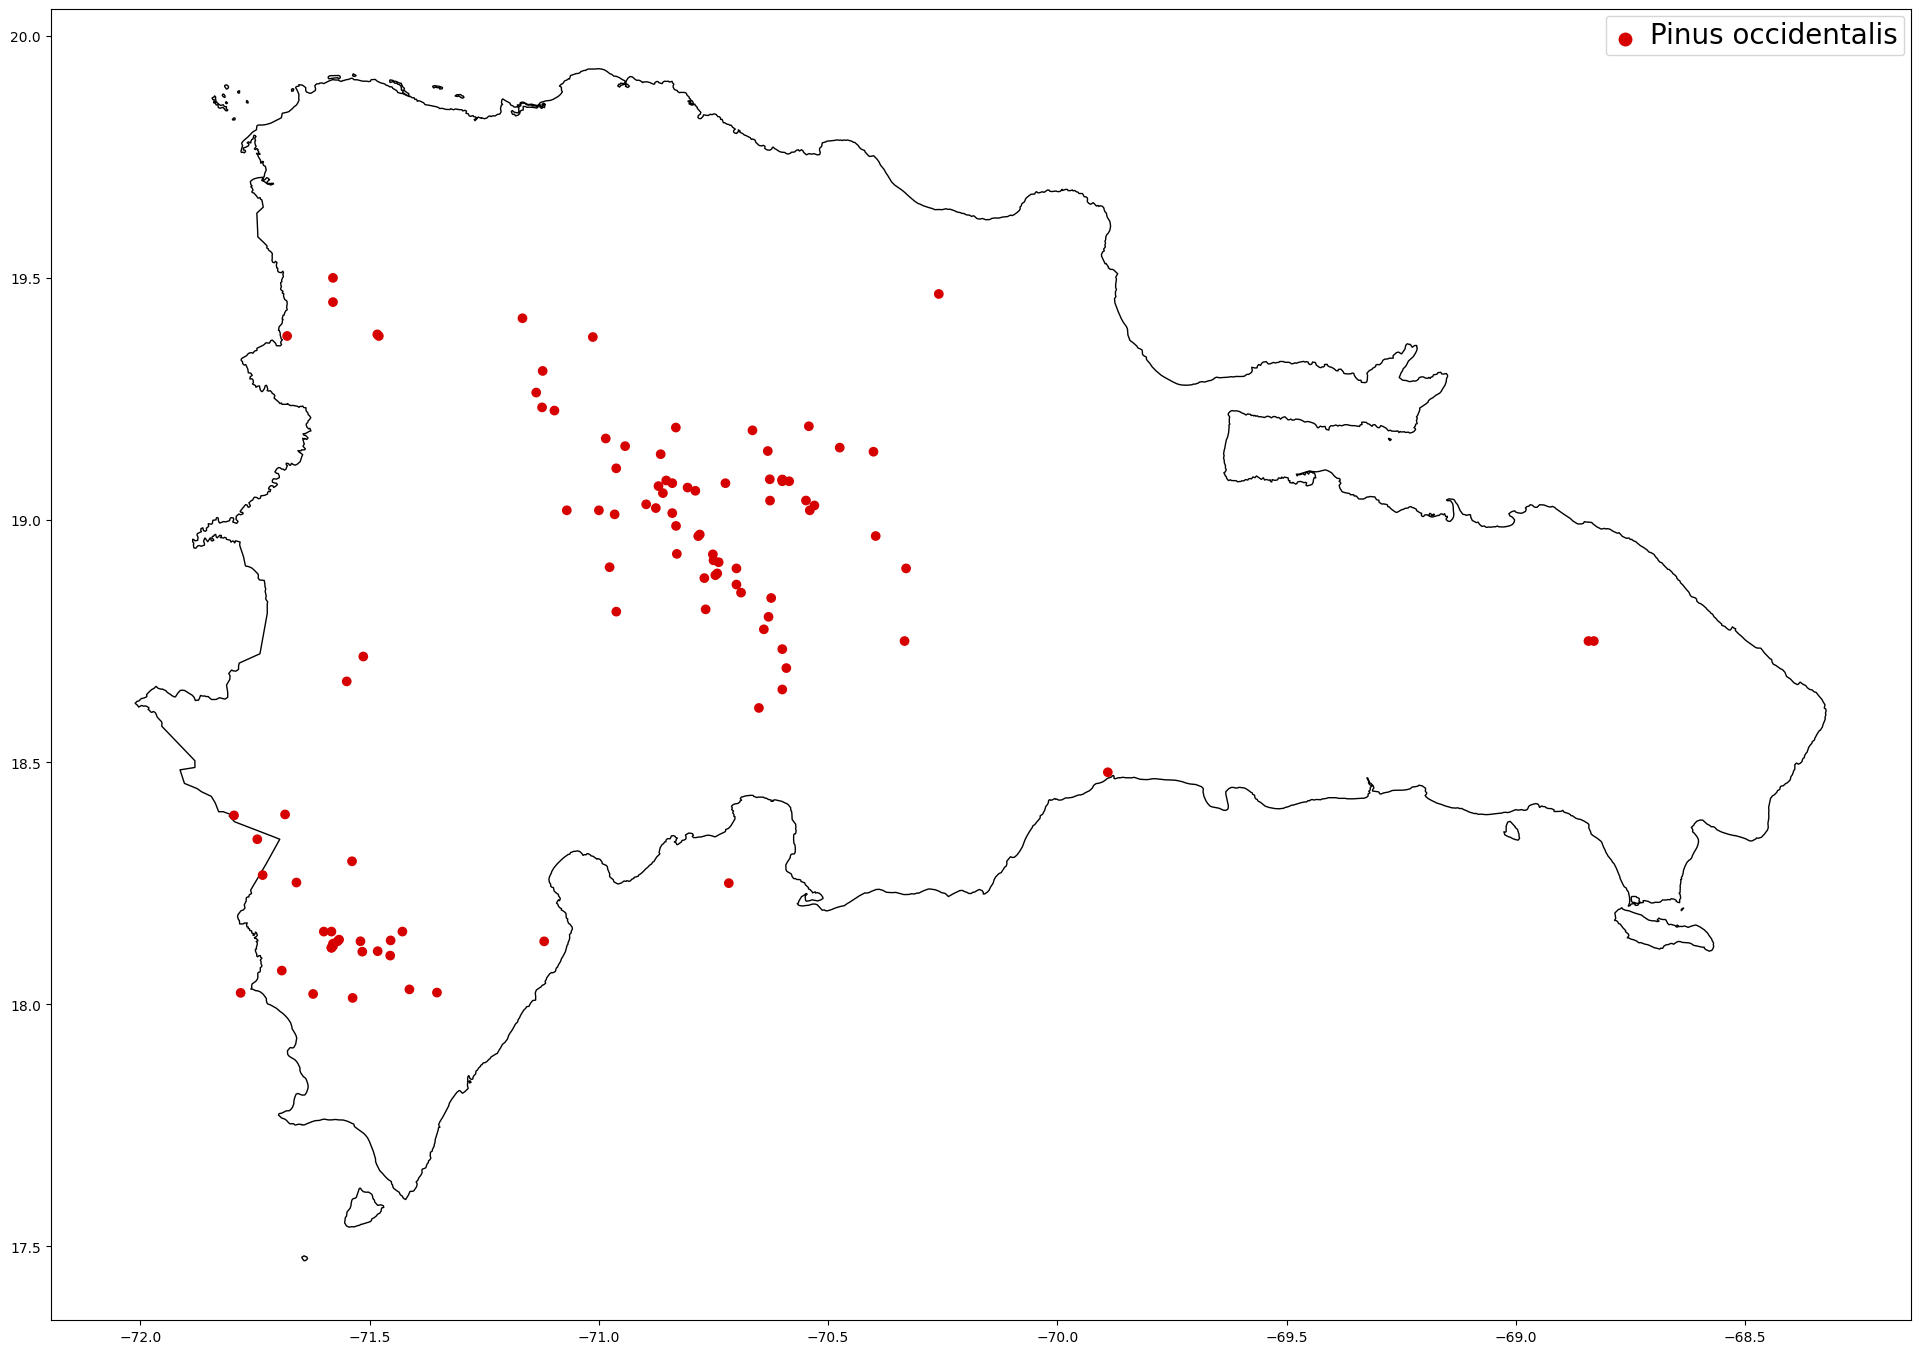

In [18]:
# Mapa base
rd_url = 'https://github.com/biogeografia-202202/material-de-apoyo/raw/master/data/d002/rd.gpkg'
rd = gpd.read_file(rd_url, layer = 'pais')
rd_base = rd.plot(color='white', edgecolor='black', figsize=(24,22))

# Columna de salida por:
col_salida_en_df = salida_dic[salida_por].lower()

# Paleta
paleta_salida = ListedColormap(sns.color_palette(cc.glasbey, n_colors=len(gdf[col_salida_en_df].unique())))

# Puntos de GBIF
gdf.plot(column=col_salida_en_df, ax=rd_base, cmap=paleta_salida, legend=True, markersize=36)

# Aumentar el tamaño de la leyenda
legend = rd_base.get_legend()
if legend:  # Si la leyenda existe, ajustar el tamaño de la fuente
    for text in legend.get_texts():
        text.set_fontsize(20)

plt.show()

## Exportar GeoDataFrame de datos GBIF a GeoPackage

In [19]:
gdf.to_file(filename = f'{prefijo_archivo}-desde-python.gpkg', driver='GPKG')

INFO:Created 103 records


# Datos ambientales

## Estadística zonal basada índice espacial H3

Te dejo una información básica sobre H3. Es un sistema de indexación geoespacial que divide el mundo en celdas hexagonales. H3 es de código abierto bajo la licencia Apache 2. La H3 Core Library implementa el sistema de cuadrículas H3. Incluye funciones para convertir coordenadas de latitud y longitud a la celda H3 que las contiene, encontrar el centro de las celdas H3, encontrar la geometría de los límites de las celdas H3, encontrar los vecinos de las celdas H3, y más (H3, 2022).

Usaré (y tú también en esta práctica) celdas hexagonales H3 como índice espacial de resolución 7. El tamaño de hexágono es inversamente proporcional a la resolución H3 y, por lo tanto, a mayor resolución, mayor número de hexágonos e, igualmente, hexágonos más pequeños. En el caso de la reoslución 7, el tamaño promedio de cada hexágono es 3.8 km<sup>2</sup>, y se cuentan más de 13000 en República Dominicana.

El archivo que contiene las celdas hexagonales que usaré se encuentra en el repo de esta práctica (nombre de archivo: `all_sources_all_variables_res_7.gpkg`), y pertenece al repositorio ["Estadística zonal multipropósito sobre información geoespacial de República Dominicana, usando Google Earth Engine, Python y R"](https://github.com/geofis/zonal-statistics) (Martínez-Batlle, 2022). Se trata de un archivo en formato GeoPackage que puedes desplegar en QGIS. **Debes asegurarte de tener dicho archivo alojado en el directorio donde se encuentra tu cuaderno Jupyter para poder ejecutar la celda siguiente (y posteriores)**.

La tabla de atributos del archivo `all_sources_all_variables_res_7.gpkg` no sólo contiene un identificador único (hexadecimal) para referirse a cada hexágono de forma inequívoca, sino que también contiene información de hábitat generada mediante estadística zonal. En el [referido repositorio](https://github.com/geofis/zonal-statistics) encontrarás mucha información sobre cómo fueron generadas dichas variables y, en especial, sobre las fuentes usadas. Investiga al respecto.

In [20]:
def columnas_azar(gdf_fuente): #Sólo para impresión
    # Seleccionar el índice de la primera columna y otros tres índices al azar
    return [gdf_fuente.columns[0]] + random.sample(list(gdf_fuente.columns[1:]), 3)

In [21]:
va7 = gpd.read_file('all_sources_all_variables_res_7.gpkg')
va7 = va7.filter(regex="^(?!.*base$)") # Eliminar columnas que terminan en "base" (base en km2 para referencia porcentual, no útil para predecir)
columnas_seleccionadas_va7 = columnas_azar(va7)
# Imprimir las primeras filas de `va7` con las columnas seleccionadas
va7[columnas_seleccionadas_va7].head()

hex_id  GSL Mountain/divide  GFC-LOSS year 2003  CH-BIO bio11 mean daily mean air temperatures of the coldest quarter
0  874c88200ffffff                  0.0            1.376964                                        2980.963211                   
1  874c88201ffffff                  0.0            8.388388                                        2981.612364                   
2  874c88202ffffff                  0.0            0.000000                                        2980.192821                   
3  874c88203ffffff                  0.0            0.000000                                        2981.000000                   
4  874c88204ffffff                  0.0            4.378152                                        2980.835284

<Axes: >

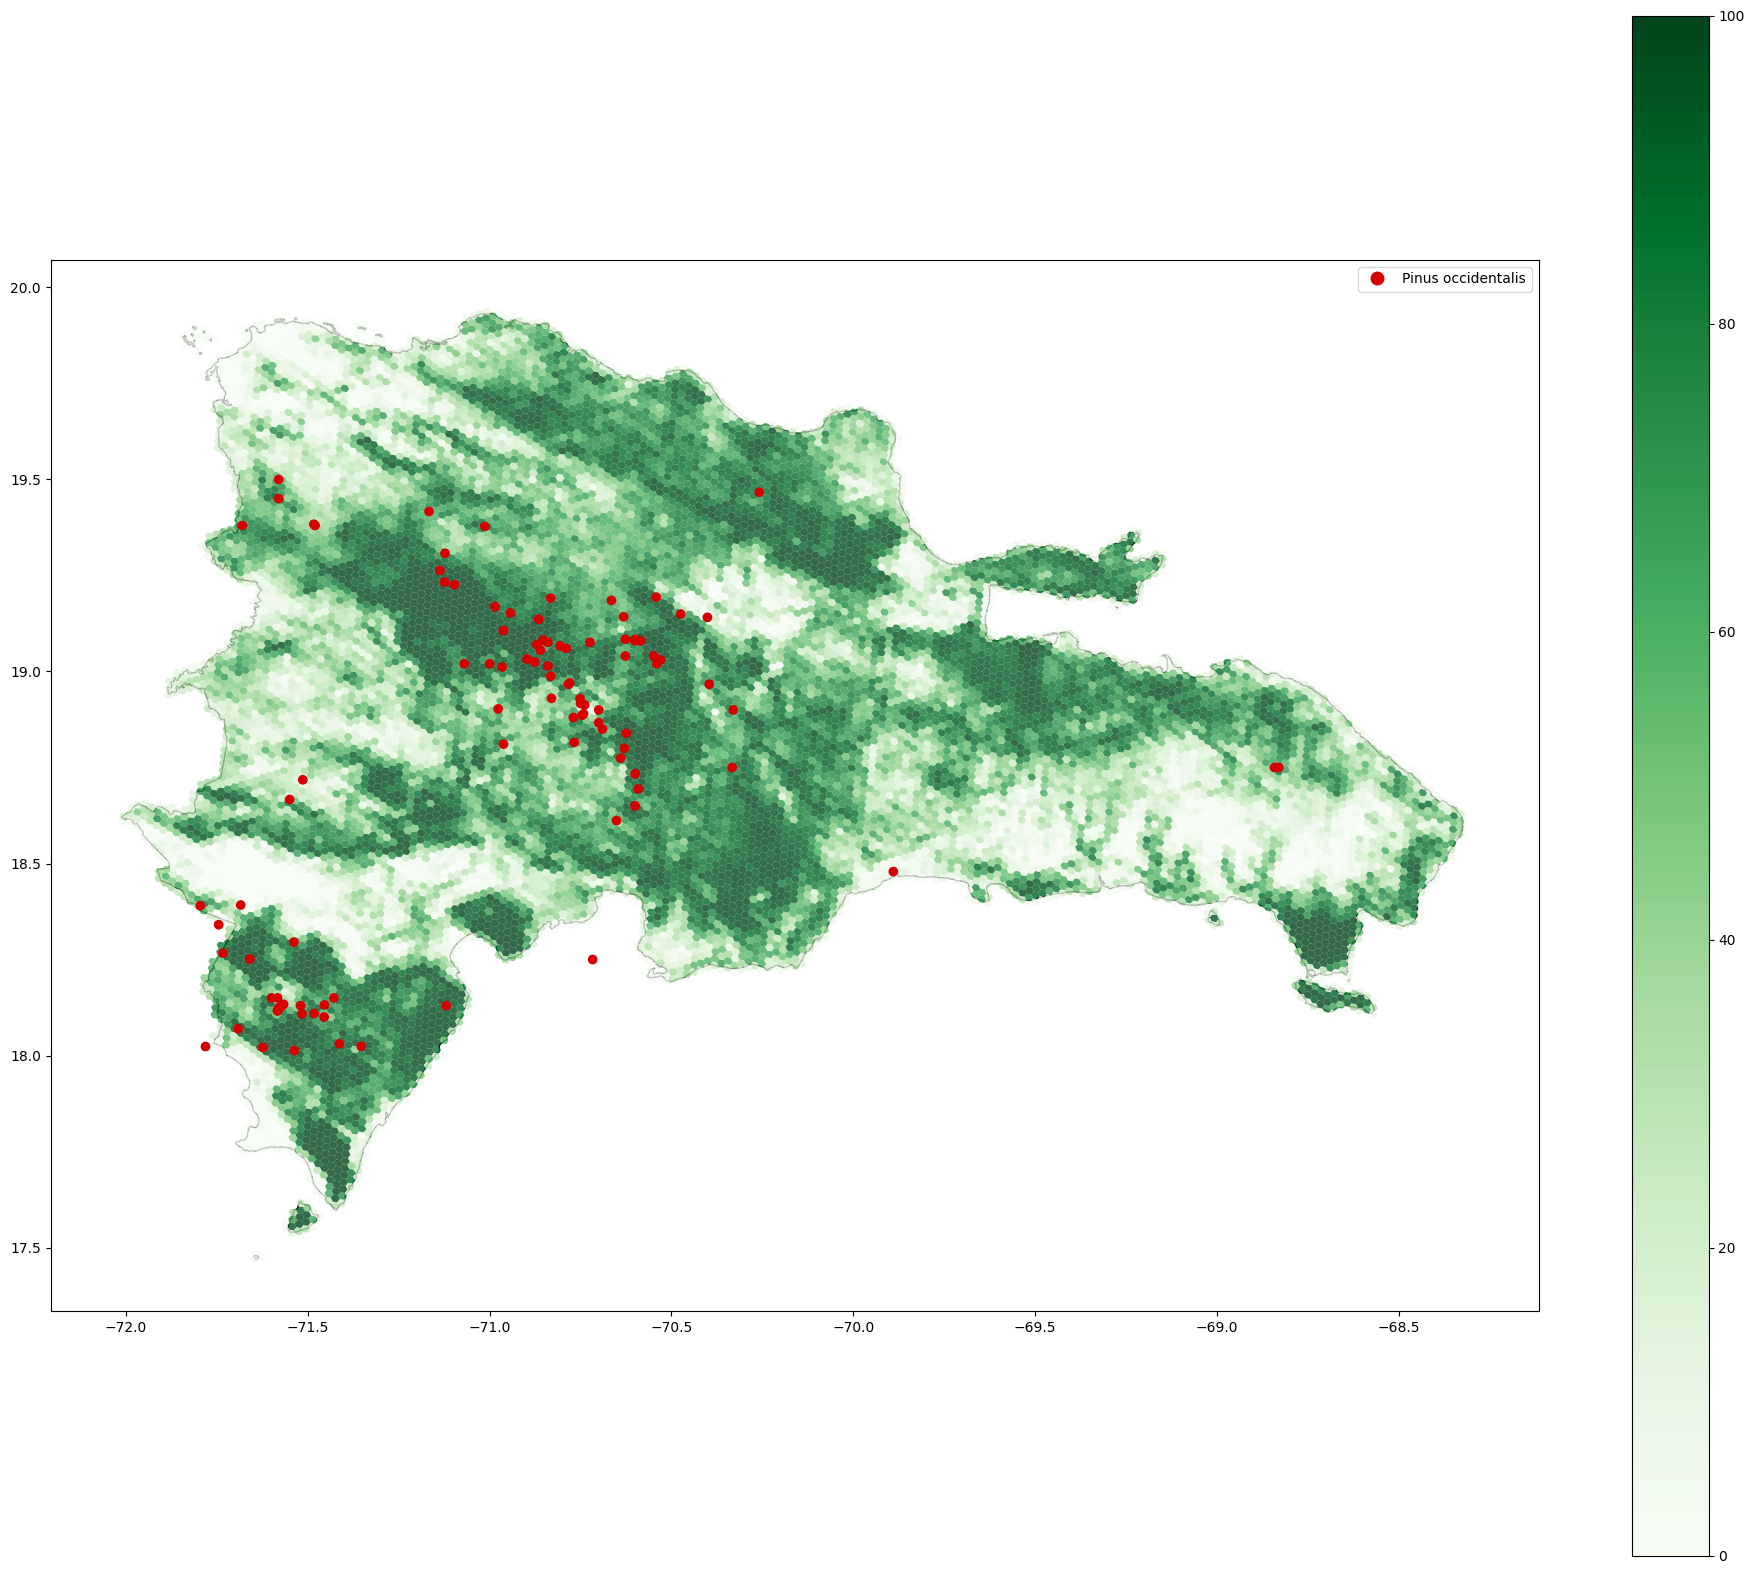

In [22]:
rd_base = rd.plot(color='white', edgecolor='black', figsize=(24,20))
va7_base = va7.plot(column='ESA Trees', ax = rd_base, legend=True, cmap='Greens', alpha = 0.8)
gdf.plot(column=col_salida_en_df, ax = va7_base, cmap=paleta_salida, legend=True, markersize=36)

# Registros de presencia, y creación de pseudoausencias

In [23]:
# Crear un GeoDataFrame `presencia` que contiene un solo punto en el centroide de cada hexágono donde hay registros.
# Realiza una intersección espacial para identificar los hexágonos que contienen puntos de `gdf`.
presencia = gpd.sjoin(va7, gdf, how="inner", predicate="contains")
# Identifica el nombre del índice automáticamente y elimina duplicados
presencia = presencia.loc[~presencia.index.duplicated()]
# Reproyecta `presencia` a un CRS proyectado antes de calcular los centroides
presencia = presencia.to_crs(epsg=32619)
presencia['geometry'] = presencia['geometry'].centroid  # Ajusta la geometría al centroide de cada hexágono
# Reproyecta de vuelta al CRS geográfico original (si fuera necesario)
presencia = presencia.to_crs(gdf.crs)
print(f'Hay {len(presencia.index)} registros de presencia no redundantes dentro de hexágonos H3')

Hay 90 registros de presencia no redundantes dentro de hexágonos H3


In [24]:
presencia = presencia[['geometry']].copy()  # Solo conservar la geometría para el resultado final.
presencia['CLASS'] = 1  # Añadir la columna CLASS con valor 1 para indicar presencia.
presencia.sample(5) # Imprimir una muestra aleatoria de cinco filas

geometry  CLASS
10071   POINT (-71.0744 19.01241)      1
771    POINT (-70.83242 19.01668)      1
745     POINT (-70.98502 19.1771)      1
9259   POINT (-71.51109 18.72343)      1
370    POINT (-71.16778 19.41367)      1

In [25]:
# Crear un nuevo GeoDataFrame para los puntos de pseudoausencia.
# Seleccionar hexágonos sin presencia para agregar puntos de pseudoausencia.
hex_sin_presencia = va7[~va7.index.isin(presencia.index)]
columnas_seleccionadas_hex_sin_presencia = columnas_azar(hex_sin_presencia)
# Imprimir las primeras filas de `va7` con las columnas seleccionadas
va7[columnas_seleccionadas_hex_sin_presencia].head()

hex_id  GHH contrast_1km  WCL bio13 Precipitation of wettest month  ESA Barren / sparse vegetation
0  874c88200ffffff      66680.686455                                 88.047659                        2.092446
1  874c88201ffffff     112709.871967                                 88.913808                        5.226920
2  874c88202ffffff     434977.054302                                 88.575606                       23.643327
3  874c88203ffffff      81302.319131                                 89.666667                        3.450763
4  874c88204ffffff      63499.346154                                 90.362876                        6.881242

In [26]:
# Limitar el número de puntos de pseudoausencia al número de puntos de presencia o al número de hexágonos sin presencia, lo que sea menor.
# Multiplicador de número de registros de presencia.
factor_pseudoausencias = 3 #E.g. 3 hará que el número de pseudoausencias sea el triple del número de registros de presencia
num_pseudoausencias = min(len(hex_sin_presencia), factor_pseudoausencias * len(presencia))
pseudoausencia_hexagonos = hex_sin_presencia.sample(n=num_pseudoausencias, random_state=1)

In [27]:
# Crear geometrías de puntos en los centroides de los hexágonos de pseudoausencia y agregar CLASS = 0.
pseudoausencia = pseudoausencia_hexagonos.copy()
pseudoausencia = pseudoausencia.to_crs(epsg=32619)
pseudoausencia['geometry'] = pseudoausencia['geometry'].centroid
pseudoausencia = pseudoausencia.to_crs(gdf.crs)
print(f'Hay {len(pseudoausencia.index)} puntos de pseudoausencias dentro de hexágonos H3')

Hay 270 puntos de pseudoausencias dentro de hexágonos H3


In [28]:
# Asignar 0 a las pseudoausencias en el campo CLASS
pseudoausencia = pseudoausencia[['geometry']]
pseudoausencia['CLASS'] = 0

In [29]:
# Combinar los GeoDataFrames de presencia y pseudoausencia en el resultado final `pa`.
pa = gpd.GeoDataFrame(pd.concat([presencia, pseudoausencia], ignore_index=True), crs=va7.crs)
pa.sample(5)

geometry  CLASS
344  POINT (-71.79327 18.70605)      0
300  POINT (-71.17843 19.70056)      0
31    POINT (-71.4744 18.10615)      1
122  POINT (-71.35524 18.99614)      0
243   POINT (-69.46822 18.9957)      0

In [30]:
# Verificación
print("Número de duplicados: ", pa.duplicated(subset='geometry', keep='first').sum())
print("Número de NA: ", pa['geometry'].isna().sum())
print("Sistema de coordenadas de referencia: {}".format(pa.crs))
print("{} observaciones (filas) con {} columnas".format(*pa.shape))

Número de duplicados:  0
Número de NA:  0
Sistema de coordenadas de referencia: EPSG:4326
360 observaciones (filas) con 2 columnas


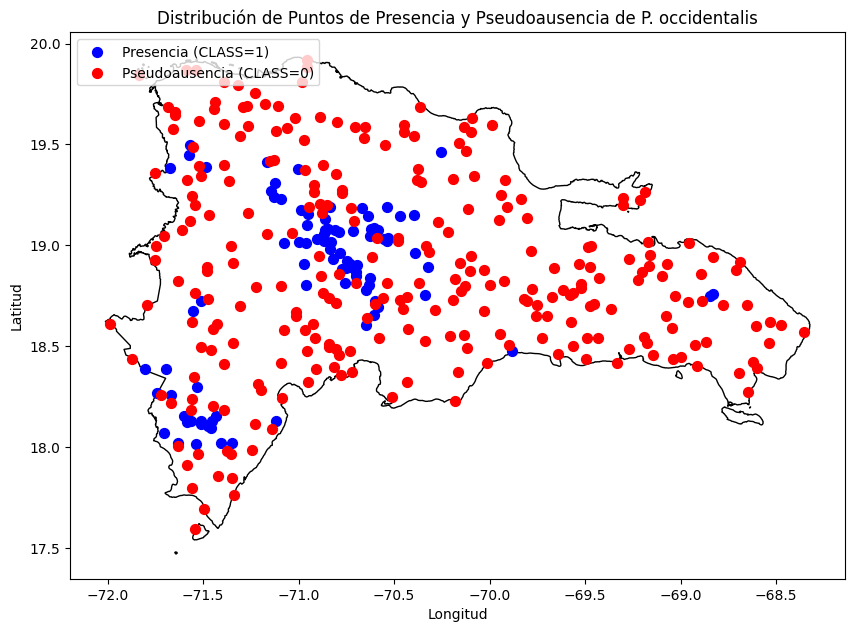

In [31]:
# Graficar el GeoDataFrame `pa` diferenciando CLASS con colores y añadiendo una leyenda manual
fig, ax = plt.subplots(figsize=(10, 10))

# Fondo con el límite del país
rd.plot(ax=ax, color='none', edgecolor='black')  # Color 'none' para que el interior sea transparente, borde negro

# Crear el gráfico, con `CLASS=1` y `CLASS=0` en diferentes colores
pa[pa['CLASS'] == 1].plot(ax=ax, color="blue", markersize=50, label="Presencia (CLASS=1)")
pa[pa['CLASS'] == 0].plot(ax=ax, color="red", markersize=50, label="Pseudoausencia (CLASS=0)")

# Configurar título y leyenda
ax.set_title("Distribución de Puntos de Presencia y Pseudoausencia de P. occidentalis")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(loc="upper left")

plt.show()

# Predictores, entrenar, predecir

## Predictores

In [32]:
# 1. Extraer características de `va7` para los puntos en `pa`
# Hacemos una unión espacial para agregar los valores de predictores desde `va7` a `pa`
pa_with_features = gpd.sjoin(pa, va7, how="left", predicate="intersects")
pa_with_features.sample(5)

geometry  CLASS  index_right           hex_id  ESA Trees  ESA Shrubland  ESA Grassland  ESA Cropland  ESA Built-up  ESA Barren / sparse vegetation  ESA Open water  ESA Herbaceous wetland  ESA Mangroves  CGL Closed forest, evergreen needle leaf  CGL Closed forest, evergreen broad leaf  CGL Closed forest, deciduous broad leaf  CGL Closed forest, mixed  CGL Closed forest, not matching any of the other definitions  CGL Open forest, evergreen needle leaf  CGL Open forest, evergreen broad leaf  CGL Open forest, deciduous broad leaf  CGL Open forest, mixed  CGL Open forest, not matching any of the other definitions  CGL Shrubs  CGL Oceans, seas  CGL Herbaceous vegetation  CGL Cultivated and managed vegetation / agriculture  CGL Urban / built up  CGL Bare / sparse vegetation  CGL Permanent water bodies  CGL Herbaceous wetland  GSL Peak/ridge (warm)  GSL Peak/ridge  GSL Mountain/divide  GSL Cliff  GSL Upper slope (warm)  GSL Upper slope  GSL Upper slope (cool)  \
183  POINT (-71.19687 18.28018)      0         9494  874cd6670ffffff  44.765816       0.621968      32.882365     21.347614      0.175712                        0.206525        0.000000                     0.0            0.0                                       0.0                                 0.000000                                      0.0                       0.0                                                0.0                                                0.0                               0.000000                                    0.0                     0.0                                          25.102443            45.543527               0.0                   8.441442                                          20.228147                0.000000                           0.0                         0.0                0.684441               0.000000             0.0                  0.0        0.0                0.000000              0.0                     0.0   
274  POINT (-71.51336 18.49655)      0         9212  874cd64c5ffffff  10.656150      72.172408      11.606445      1.651573      1.043339                        2.863878        0.006208                     0.0            0.0                                       0.0                                 0.000000                                      0.0                       0.0                                                0.0                                                0.0                               0.000000                                    0.0                     0.0                                           7.129313            90.824285               0.0                   1.894353                                           0.000000                0.152049                           0.0                         0.0                0.000000               0.000000             0.0                  0.0        0.0               38.098803              0.0                     0.0   
165    POINT (-69.044 18.58884)      0         7981  874cd594affffff   0.411289       0.000000      82.422773     16.789636      0.376301                        0.000000        0.000000                     0.0            0.0                                       0.0                                 0.000000                                      0.0                       0.0                                                0.0                                                0.0                               0.000000                                    0.0                     0.0                                           0.480631             8.517081               0.0                  24.627025                                          65.430670                0.944593                           0.0                         0.0                0.000000               0.000000             0.0                  0.0        0.0                3.415719              0.0                     0.0   
201  POINT (-69.47716 18.89001)      0        12323  87

## Gráficos (AVISO: esta celda tardará varios segundos, incluso minutos en completar su ejecución)

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


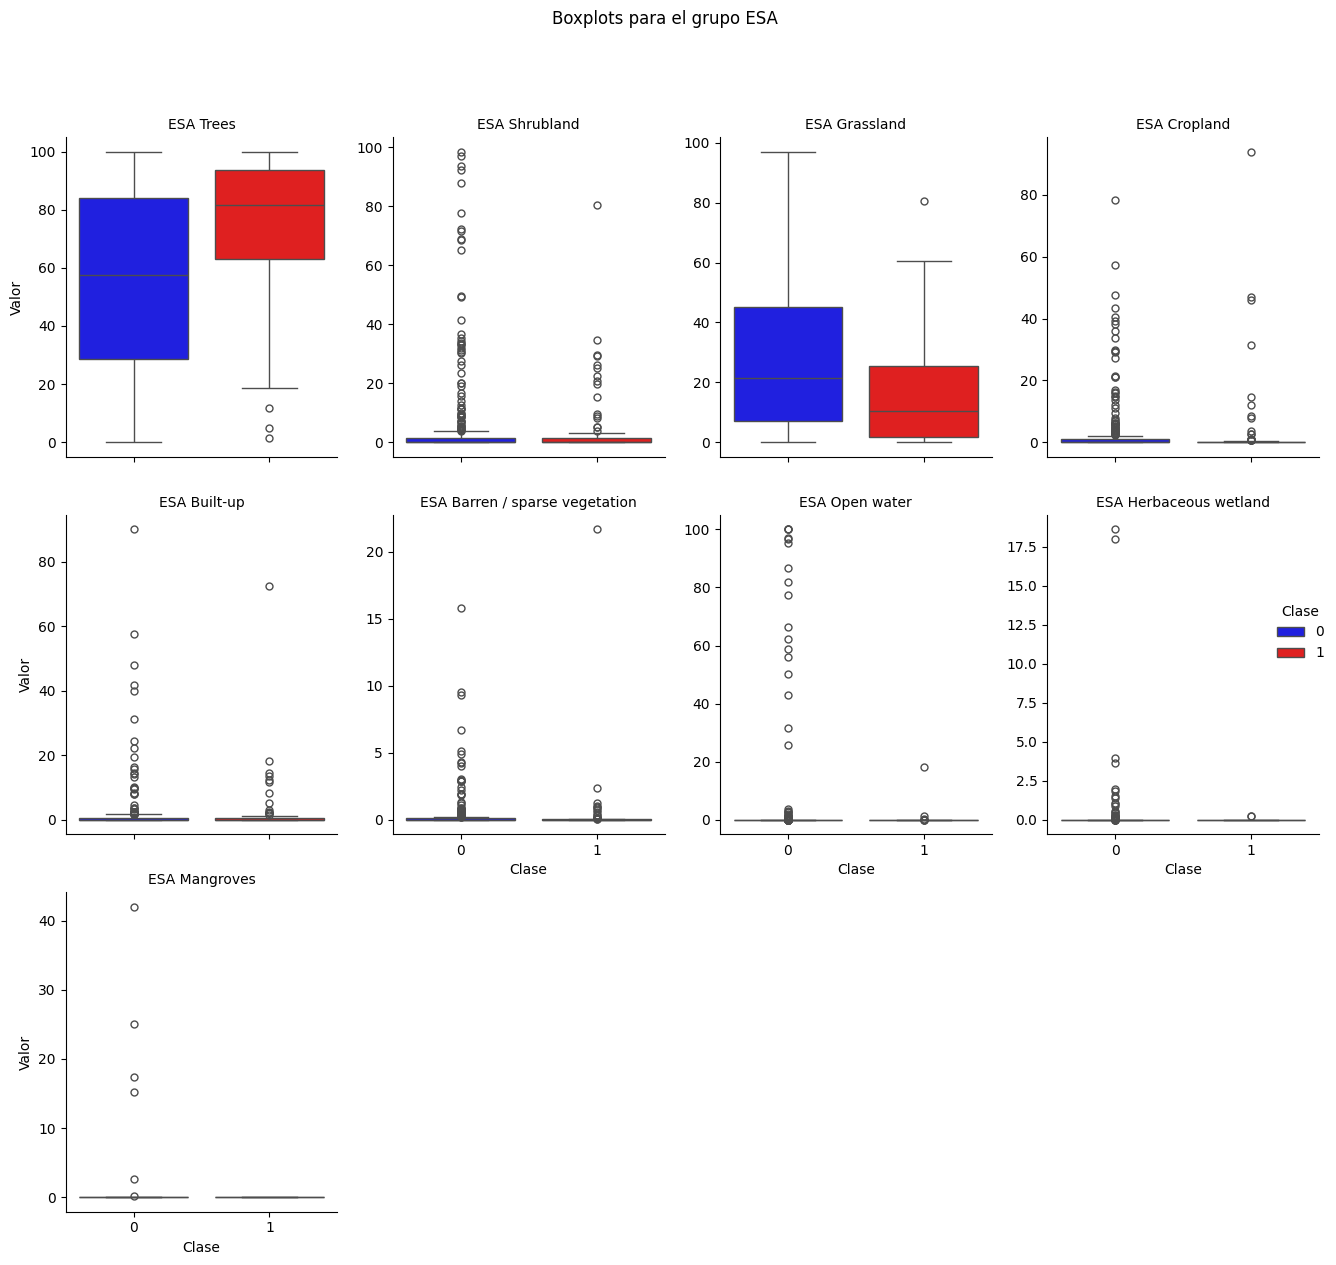

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


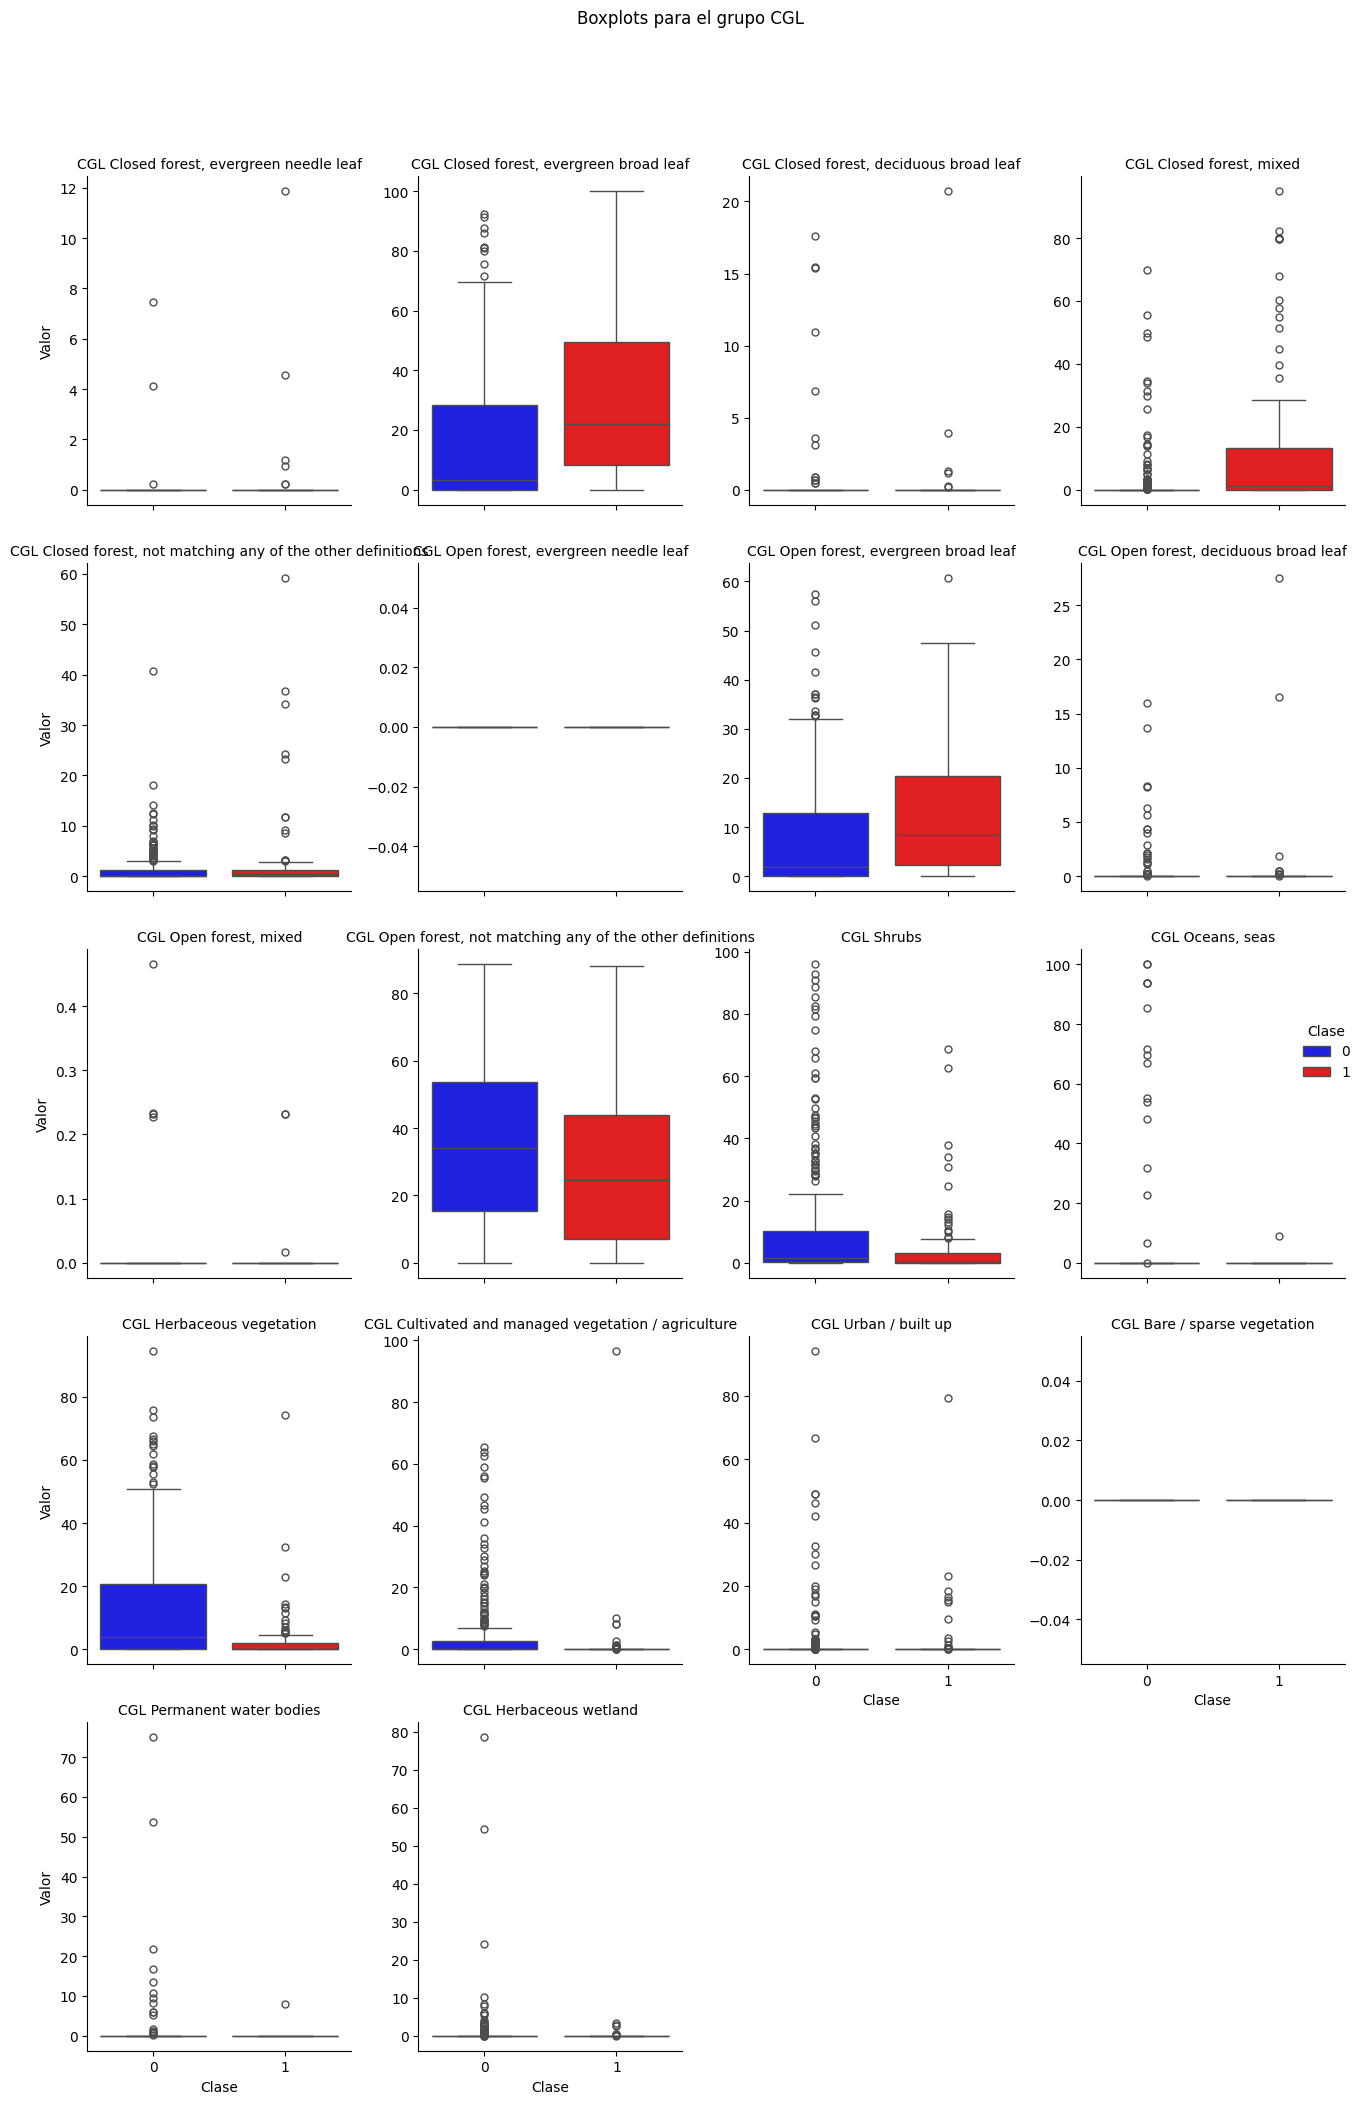

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


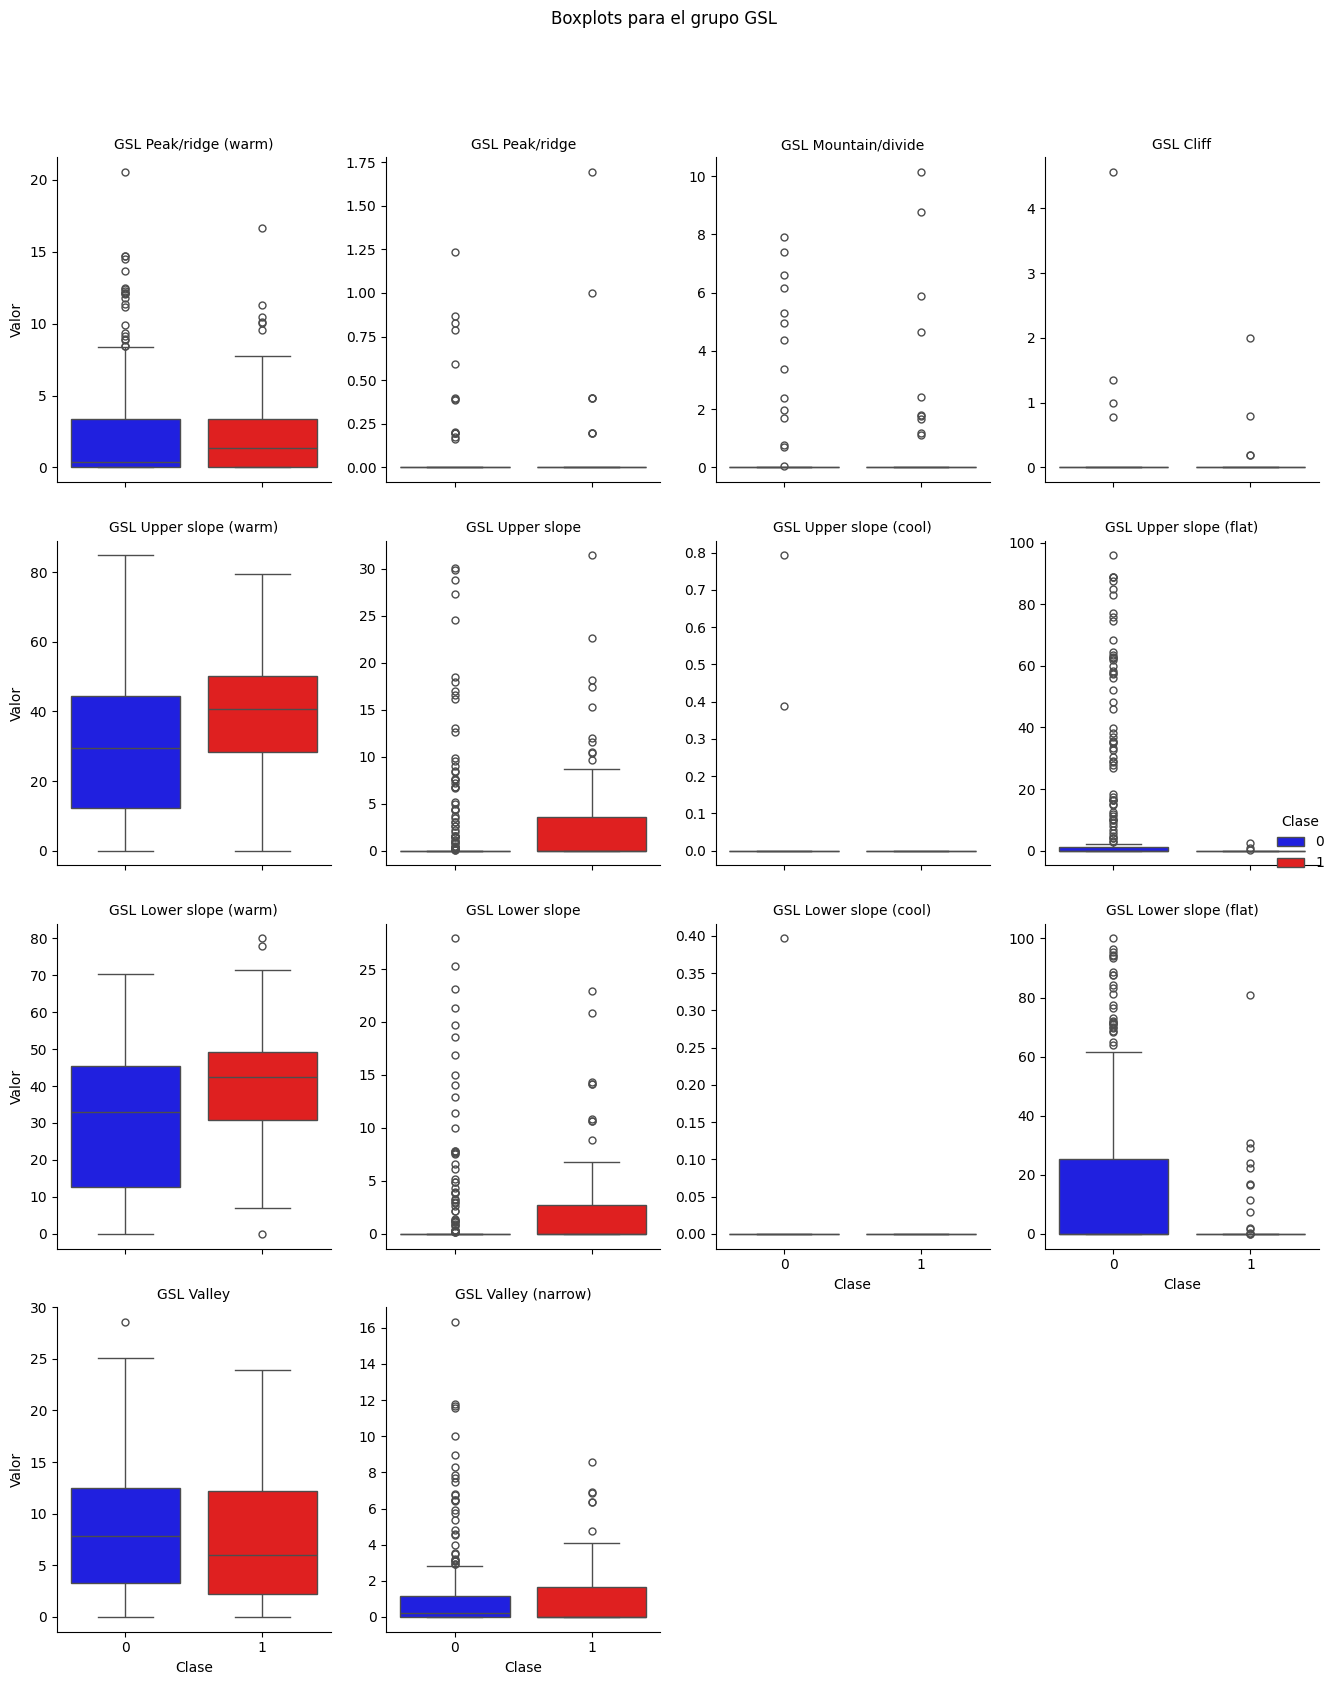

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


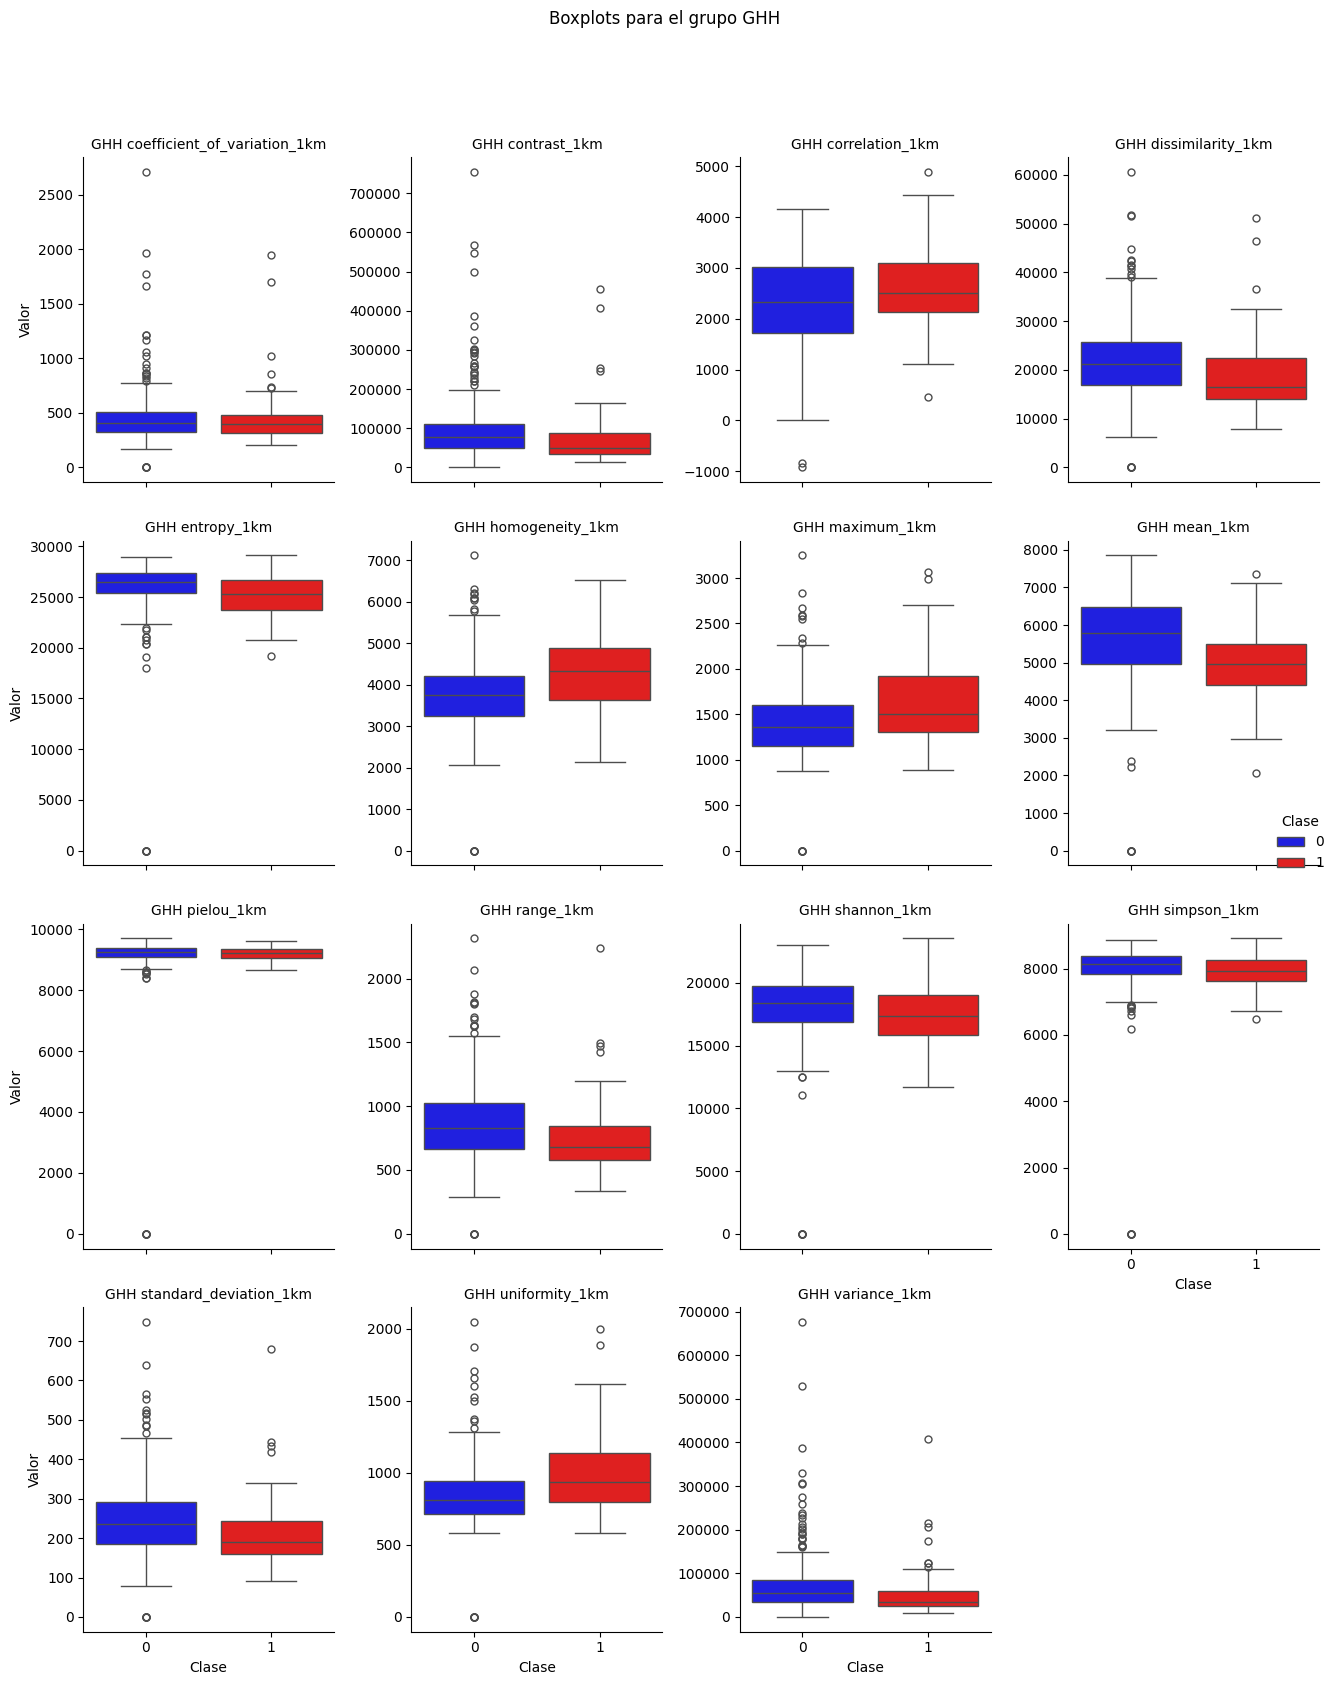

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


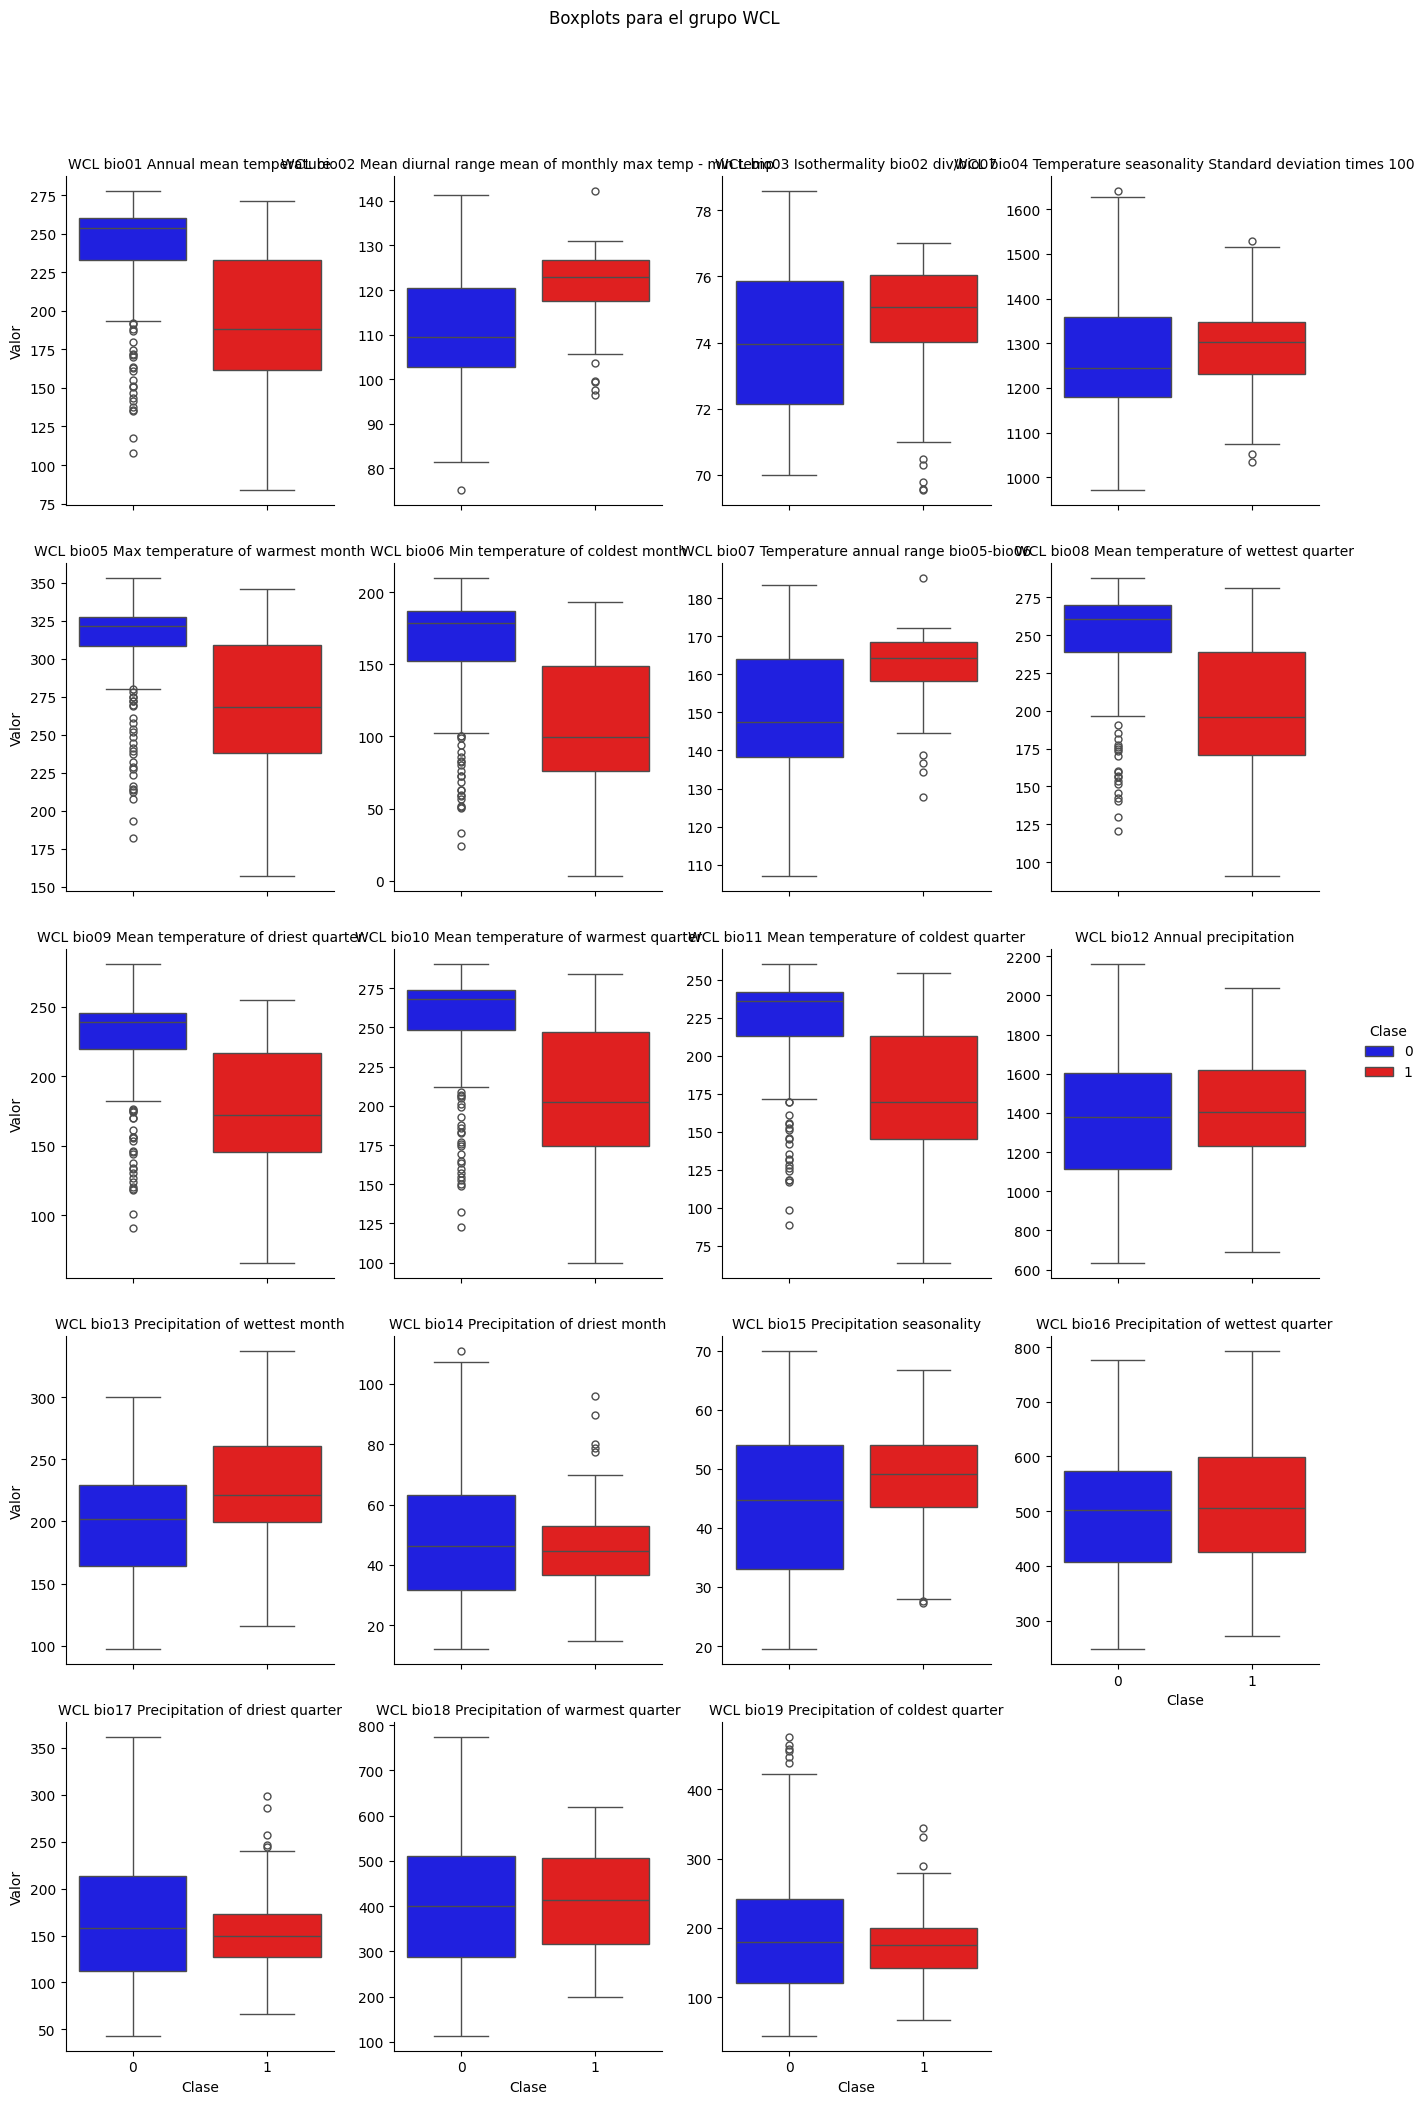

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


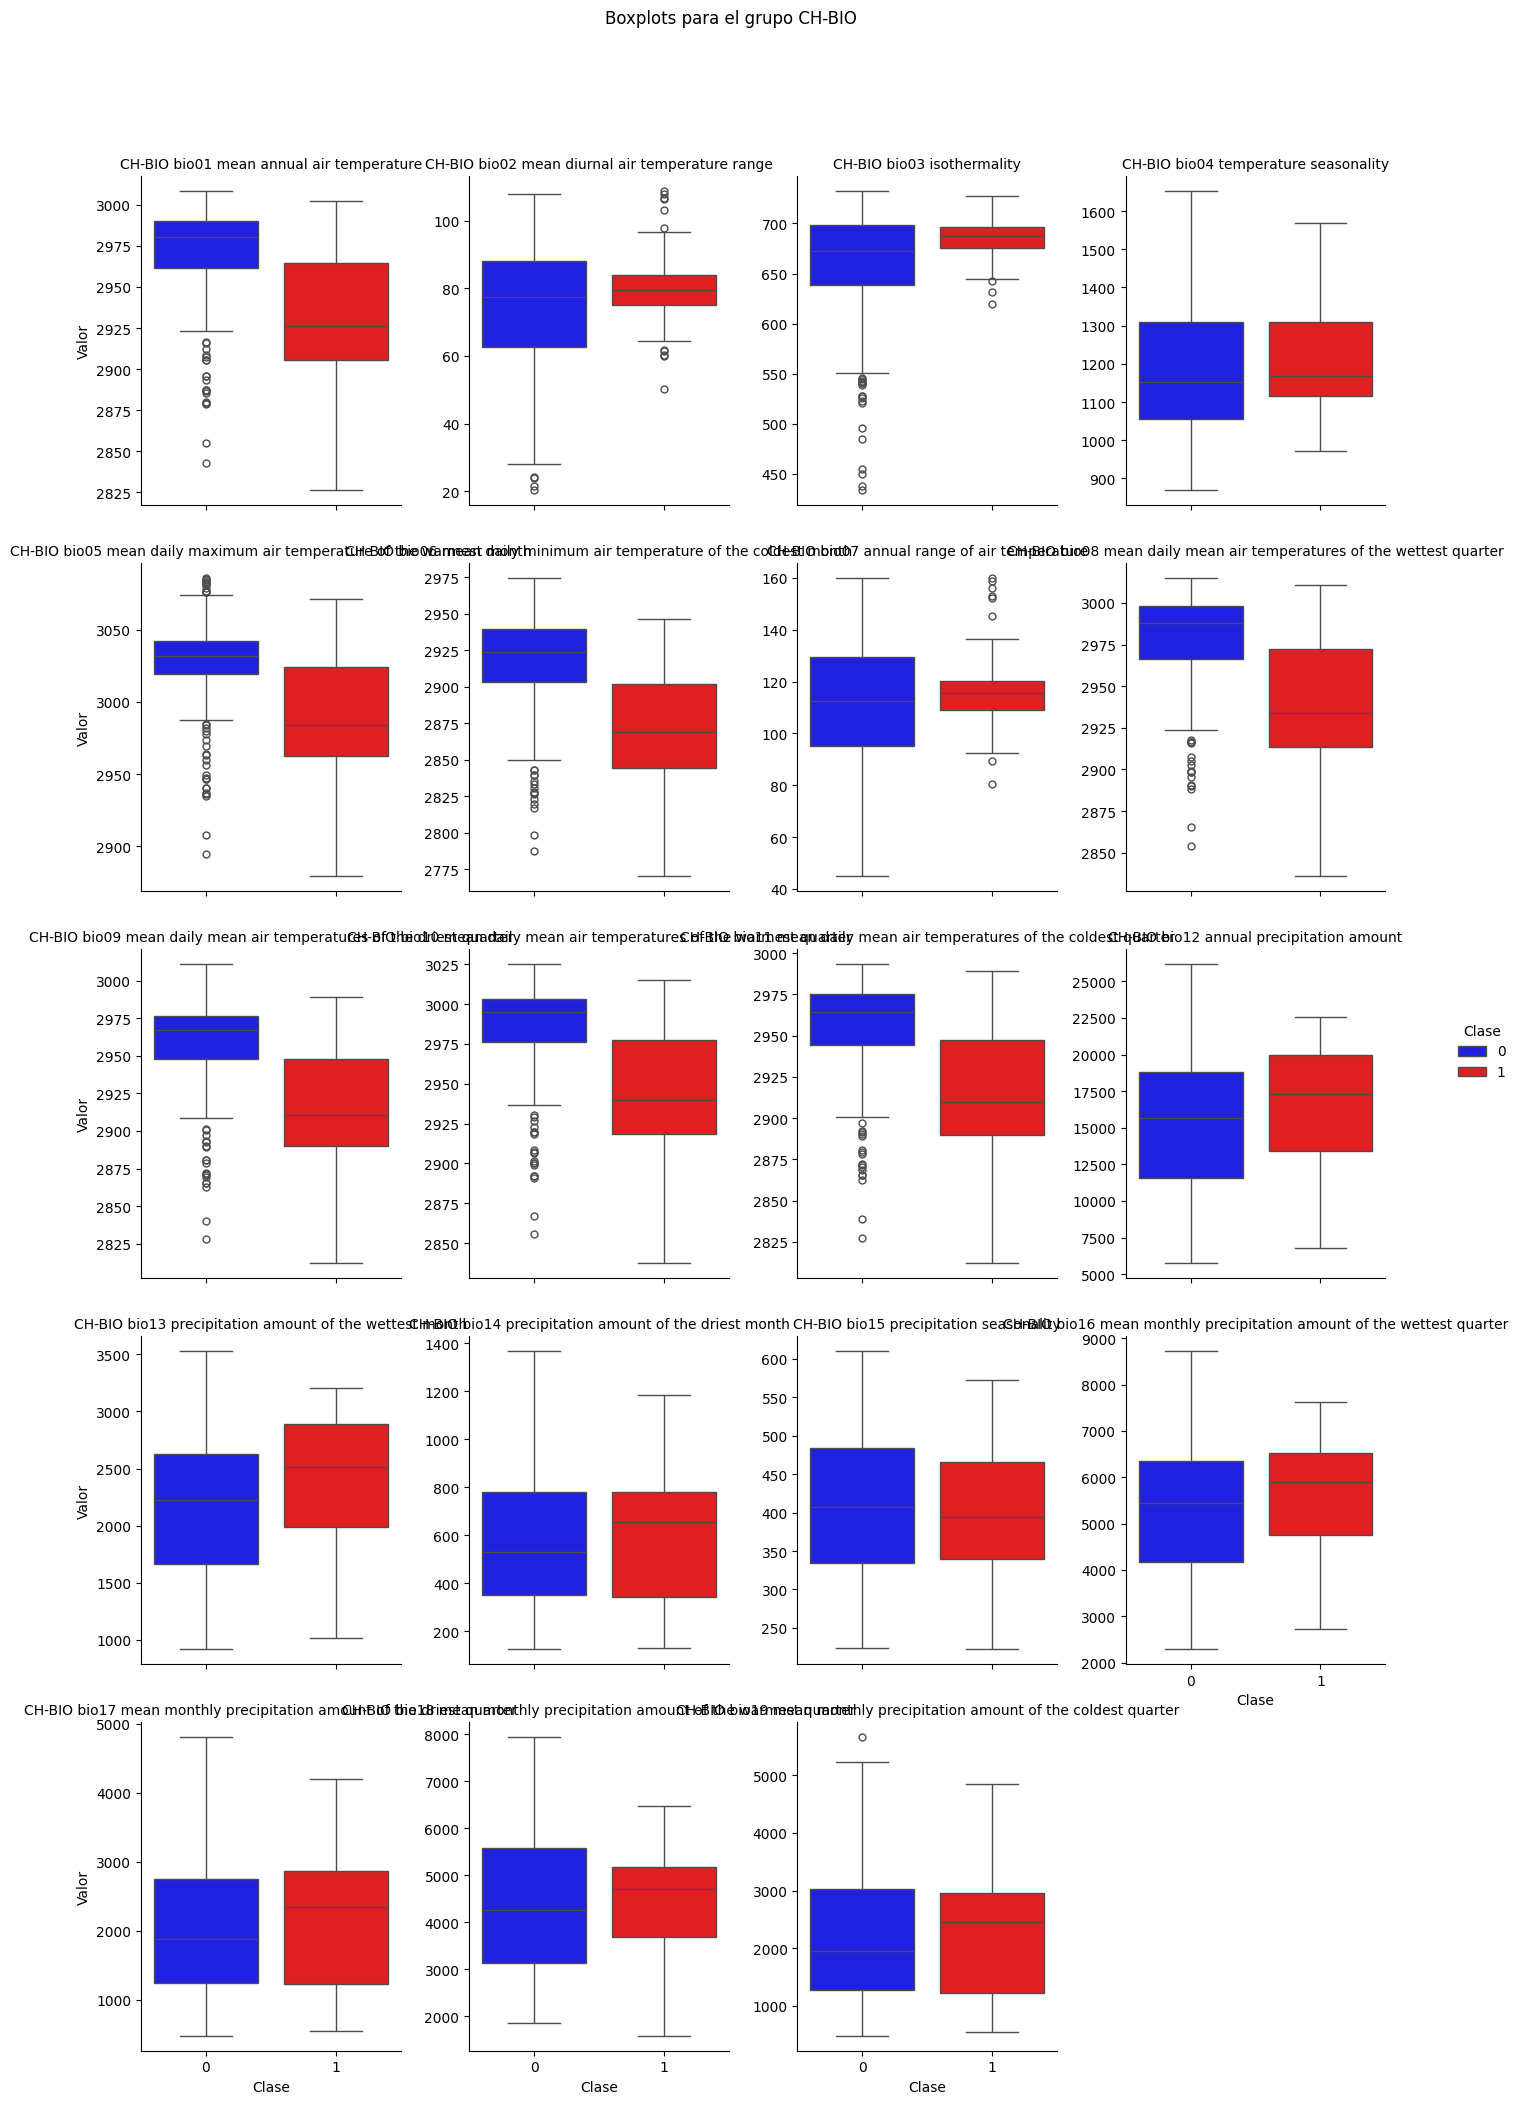

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


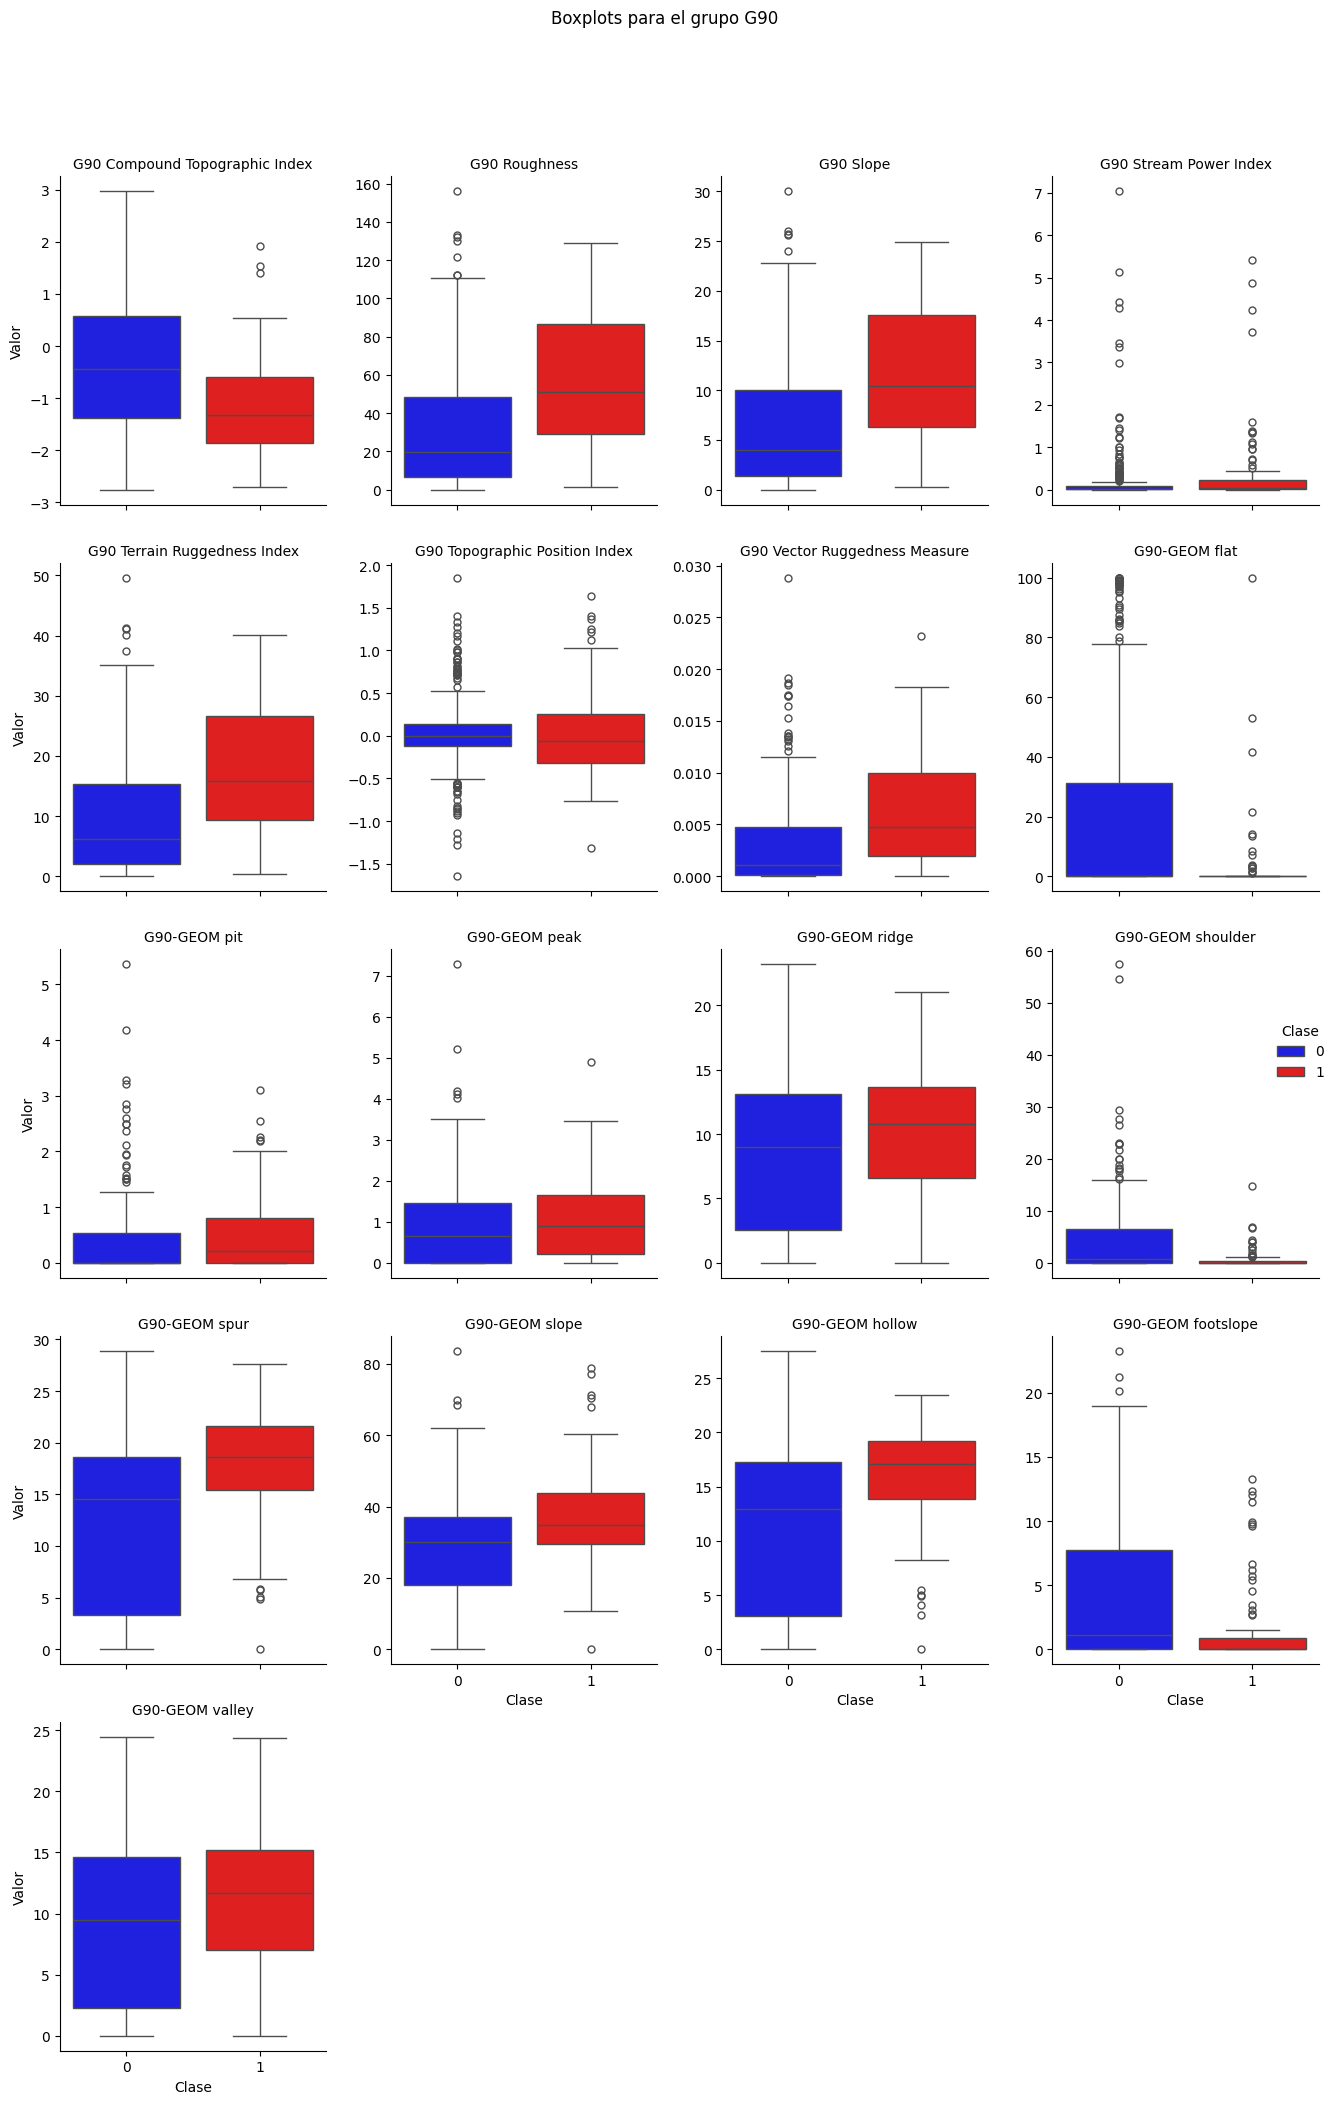

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


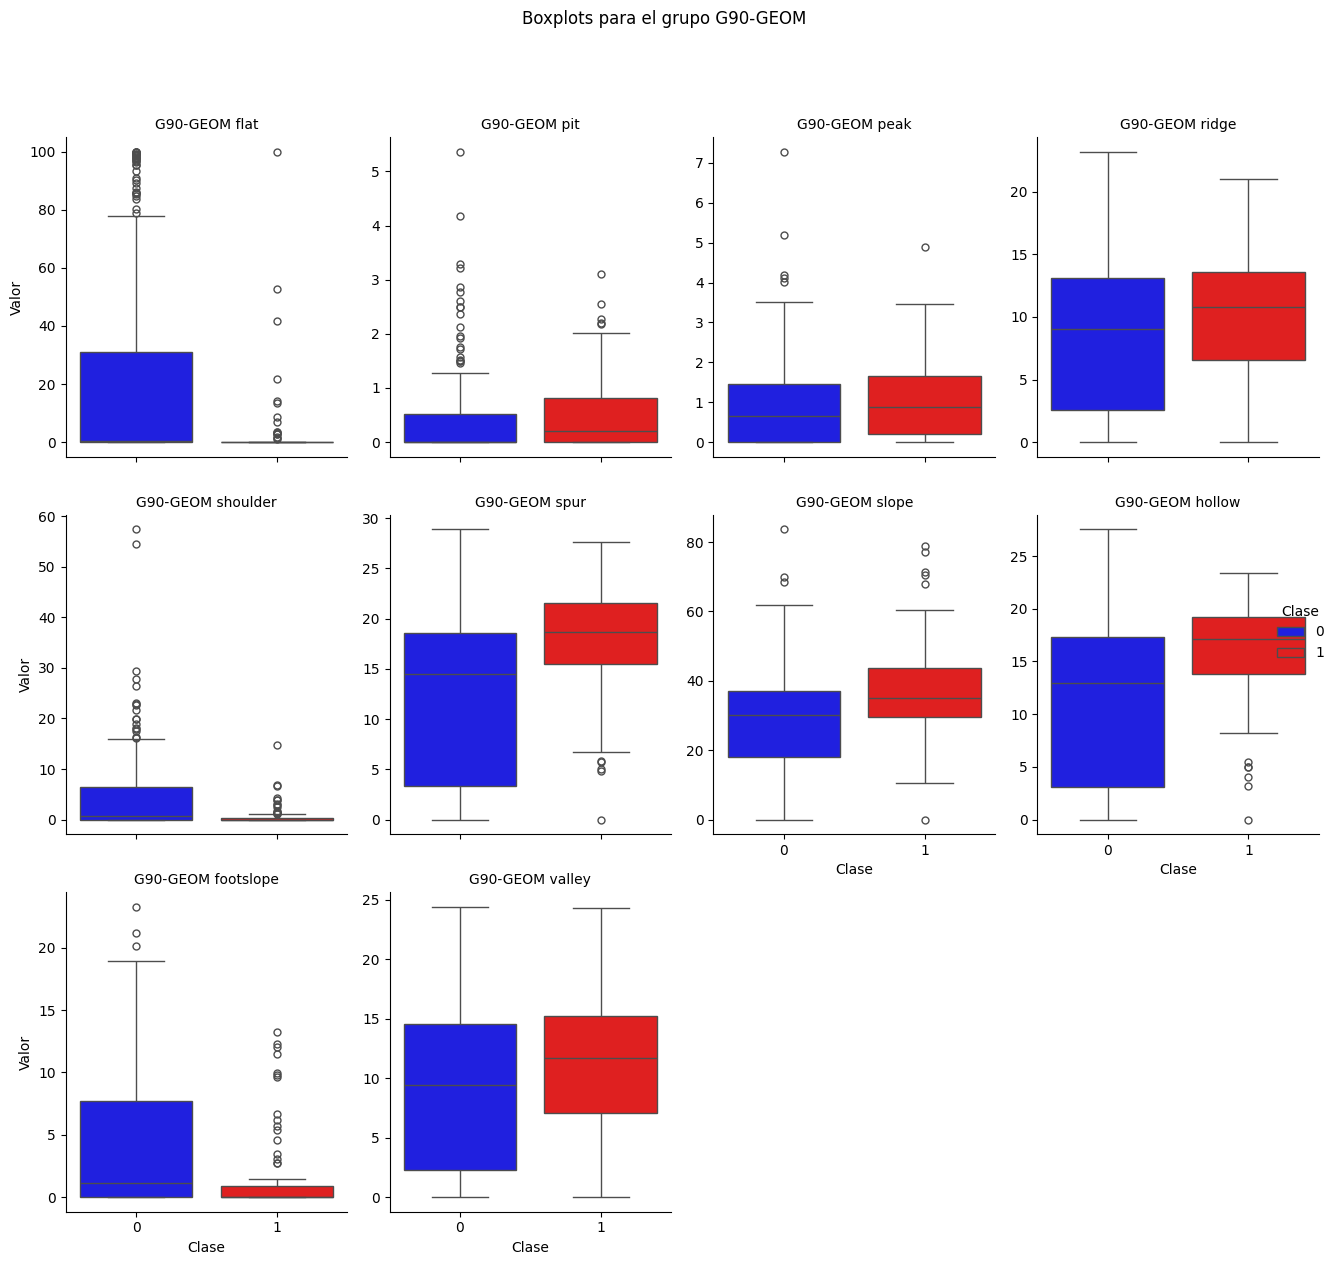

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


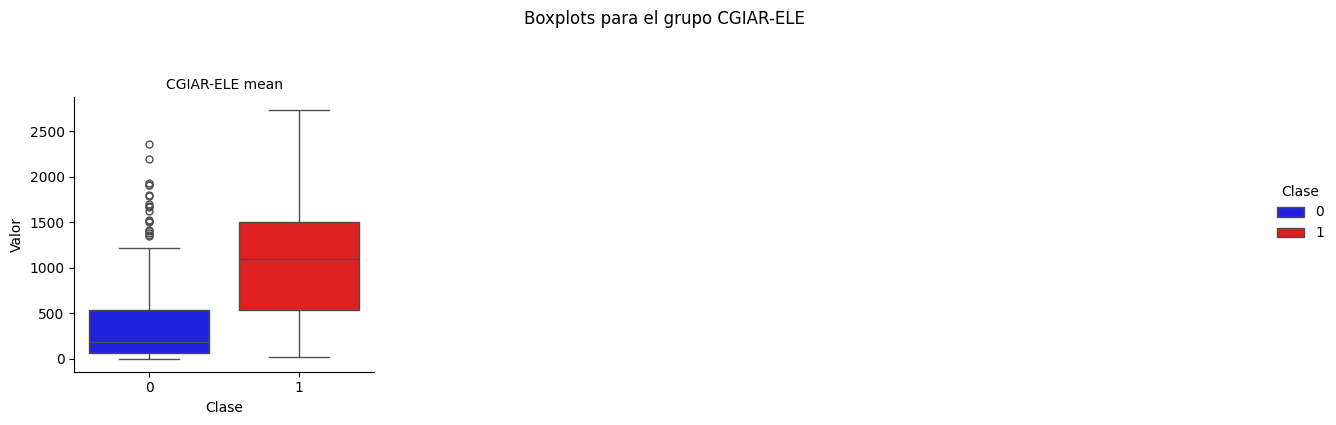

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


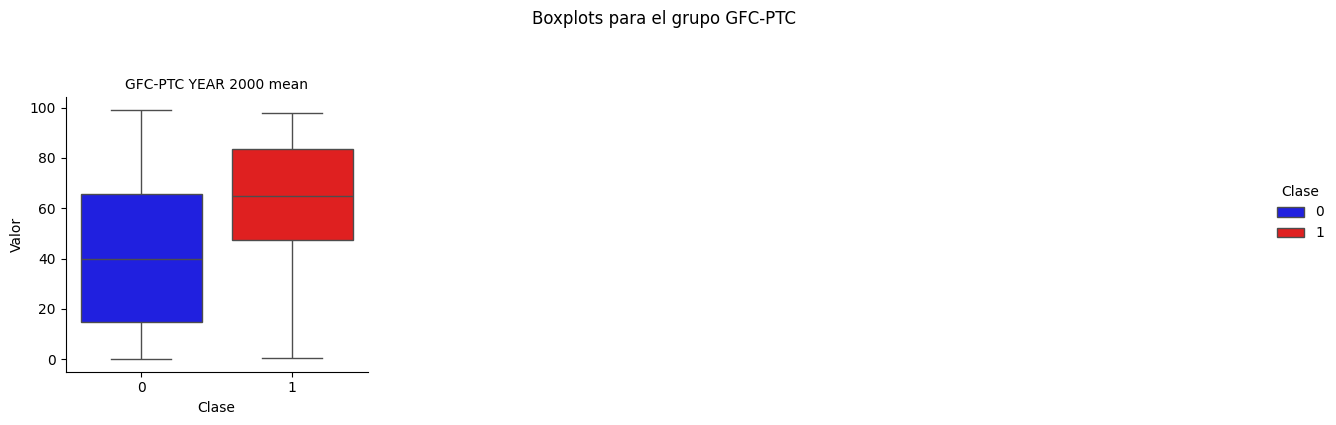

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


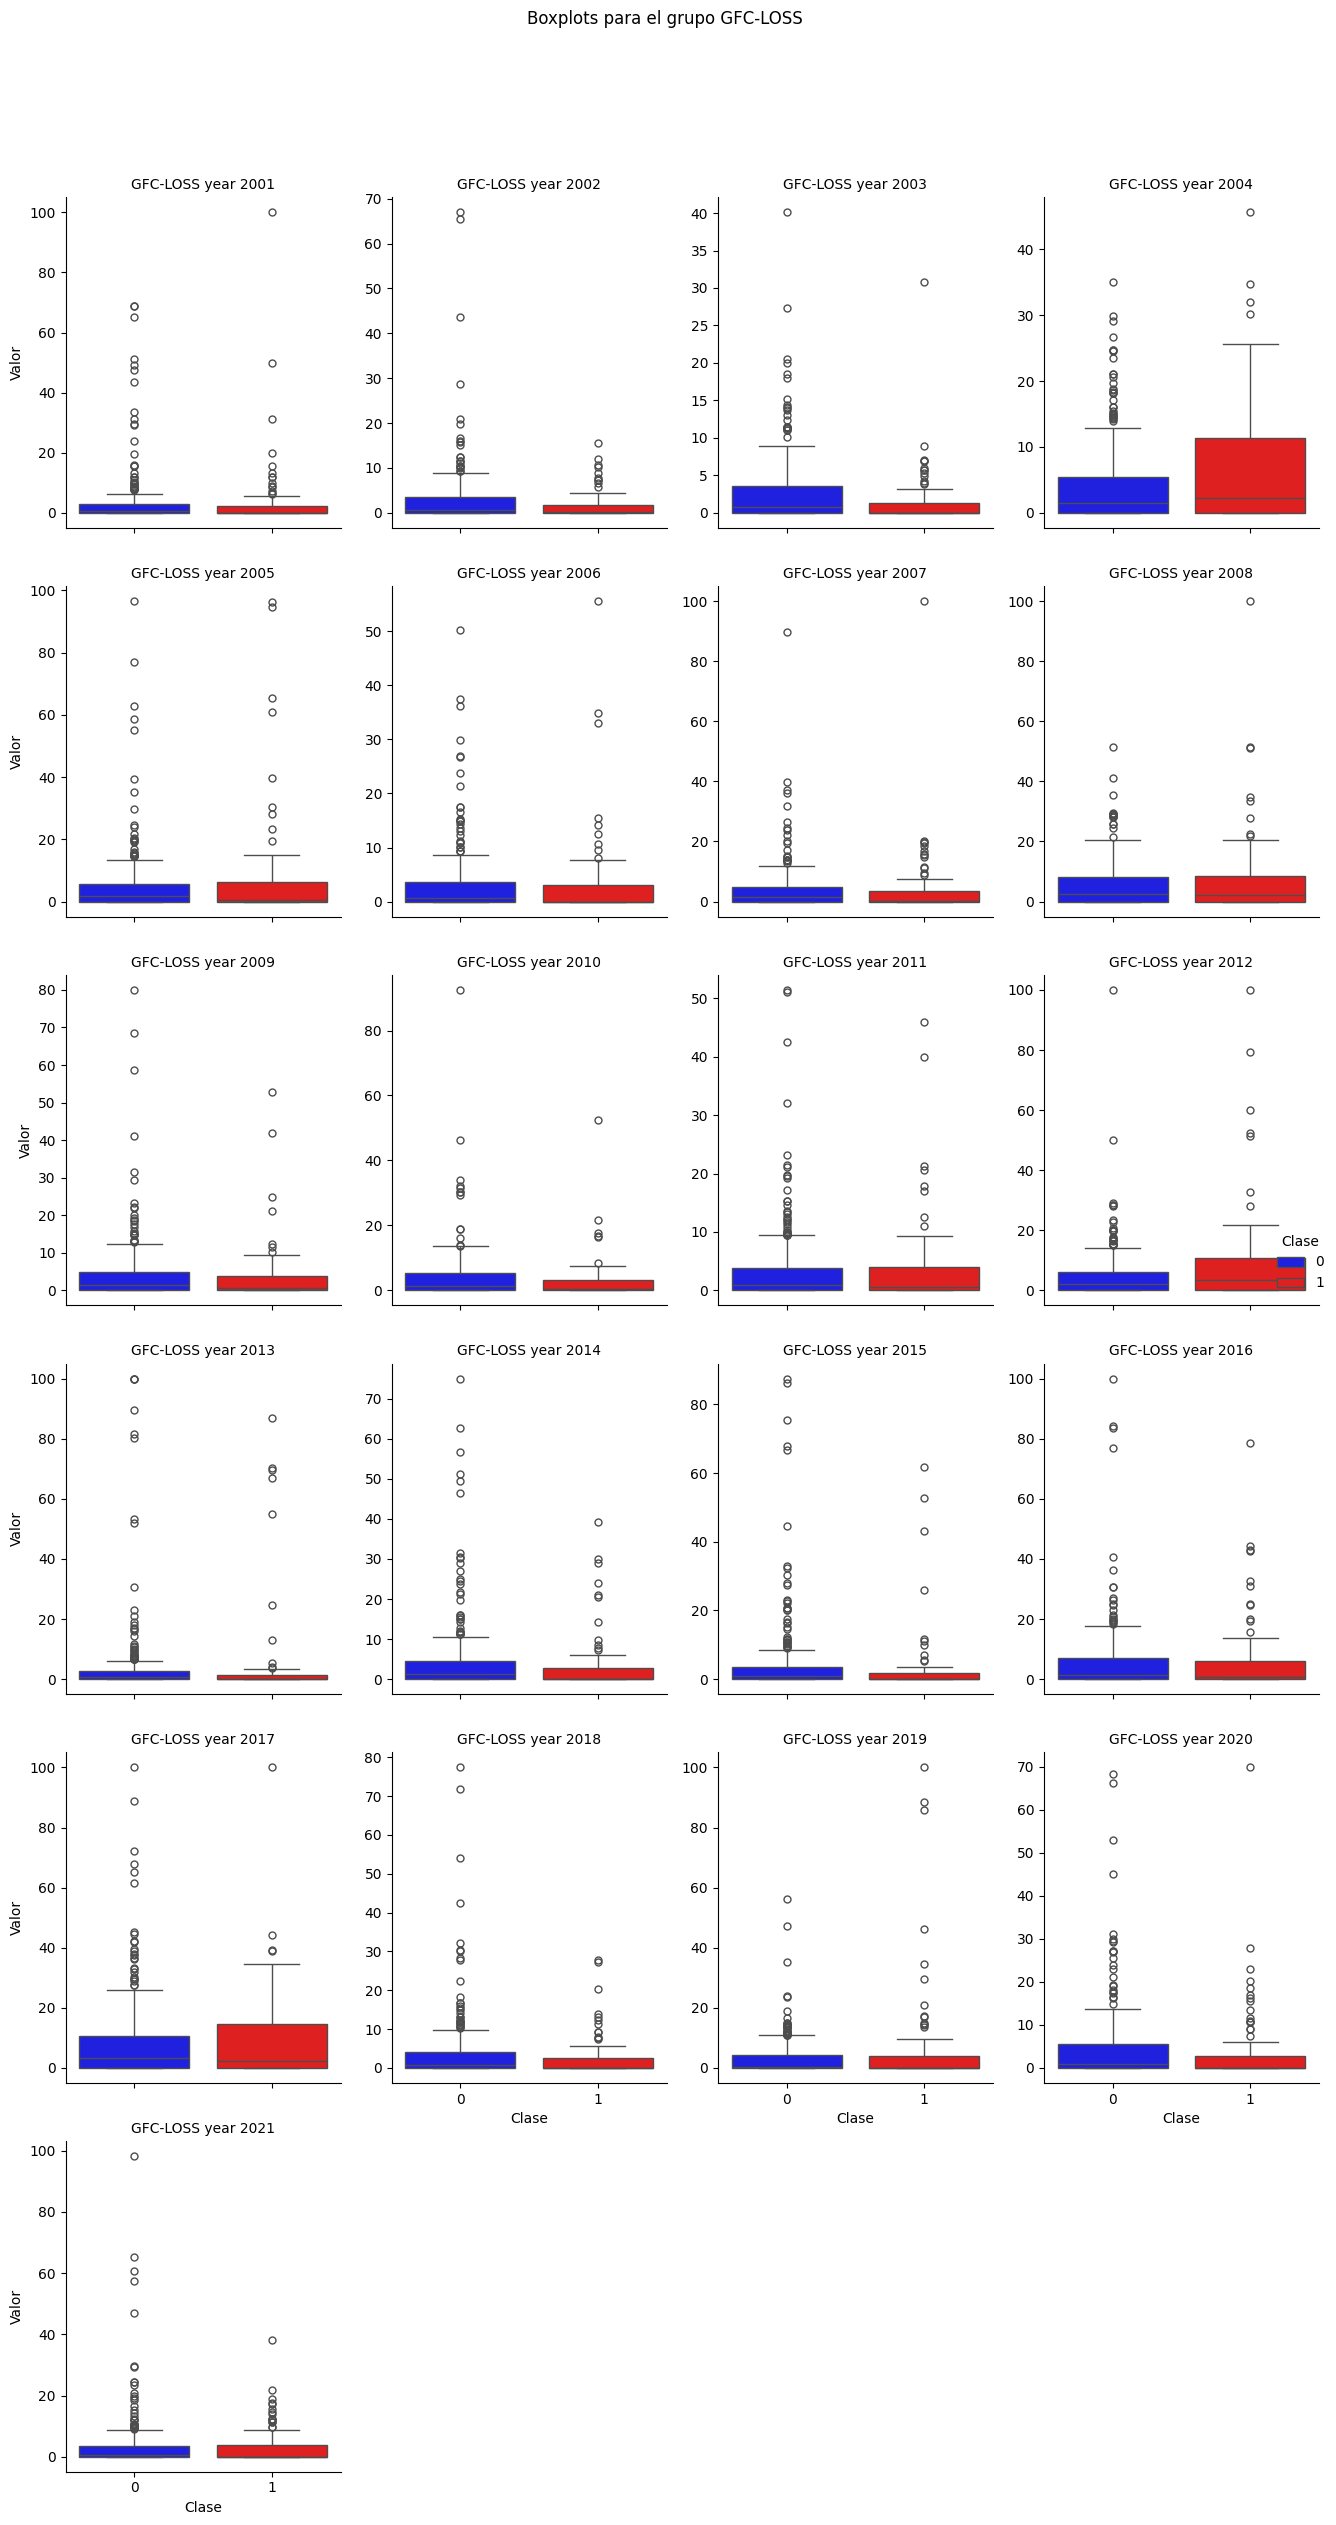

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


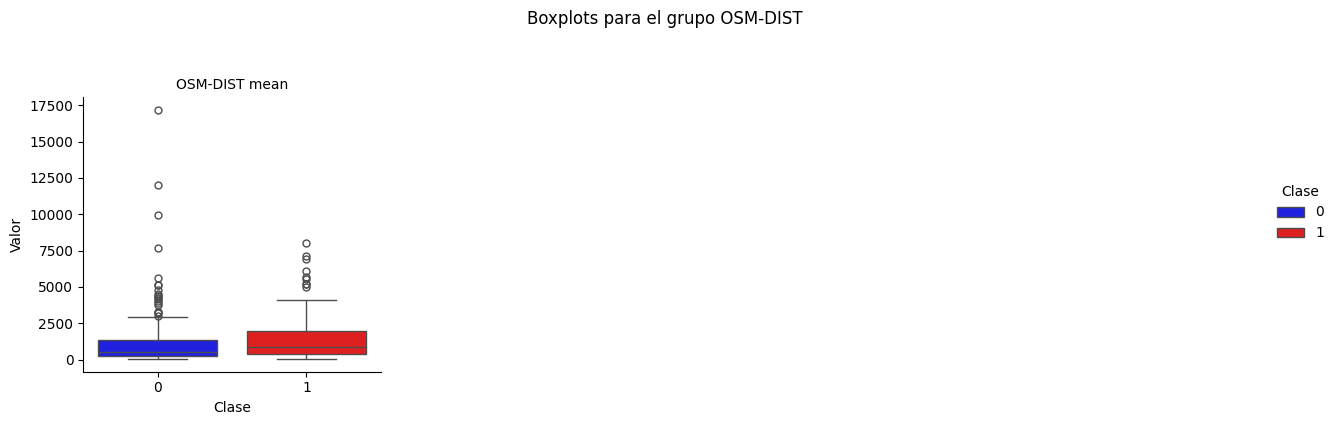

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


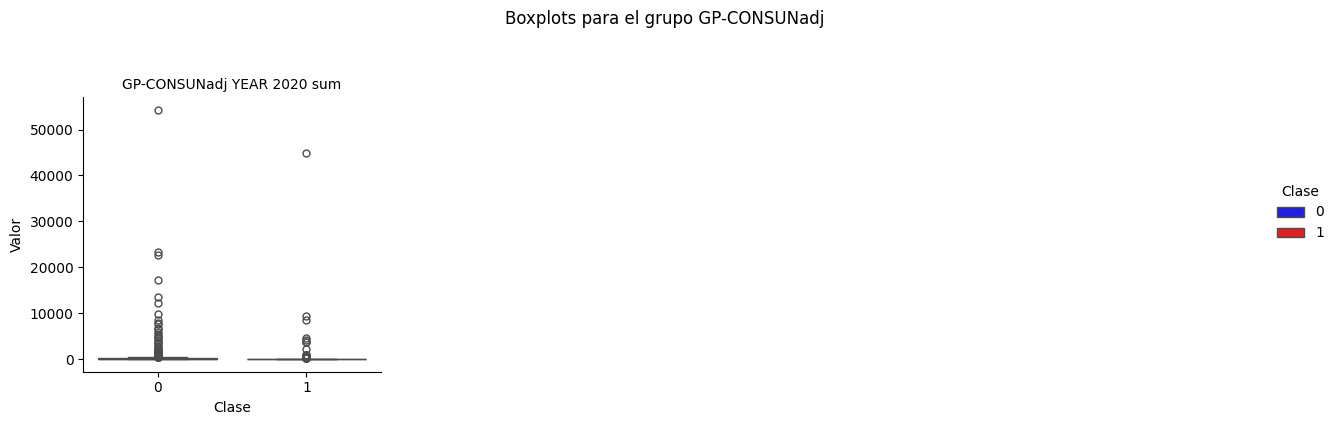

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


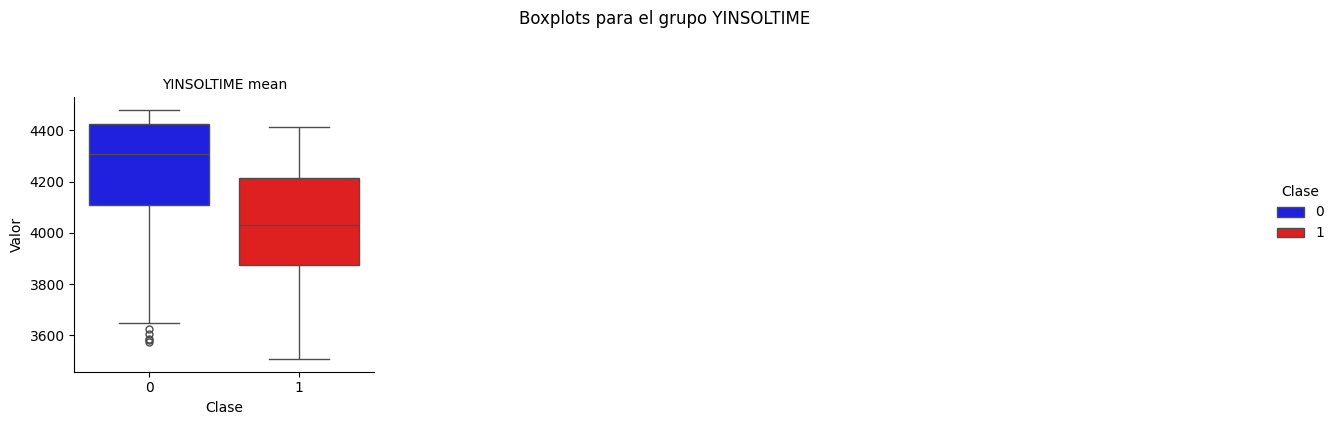

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


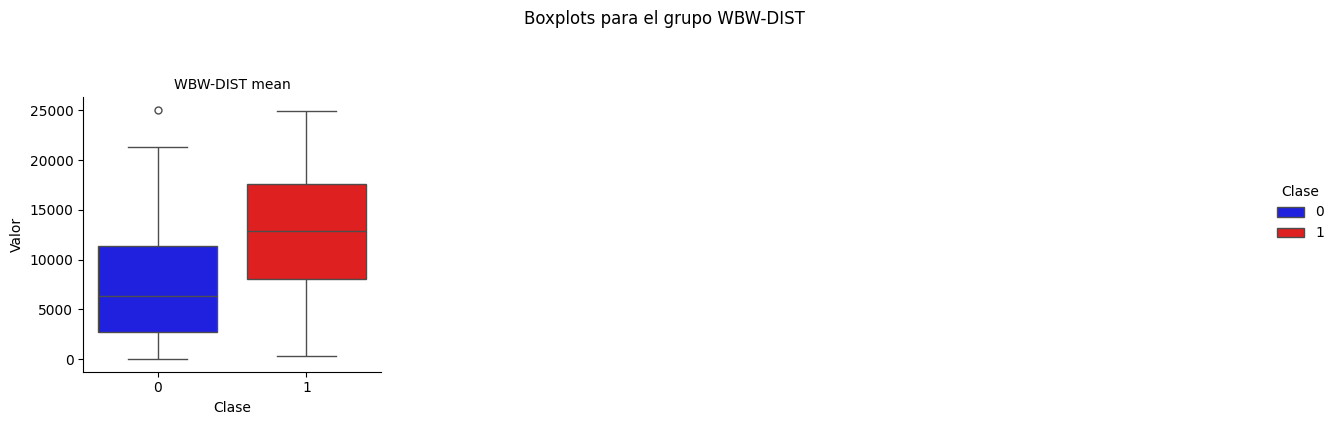

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


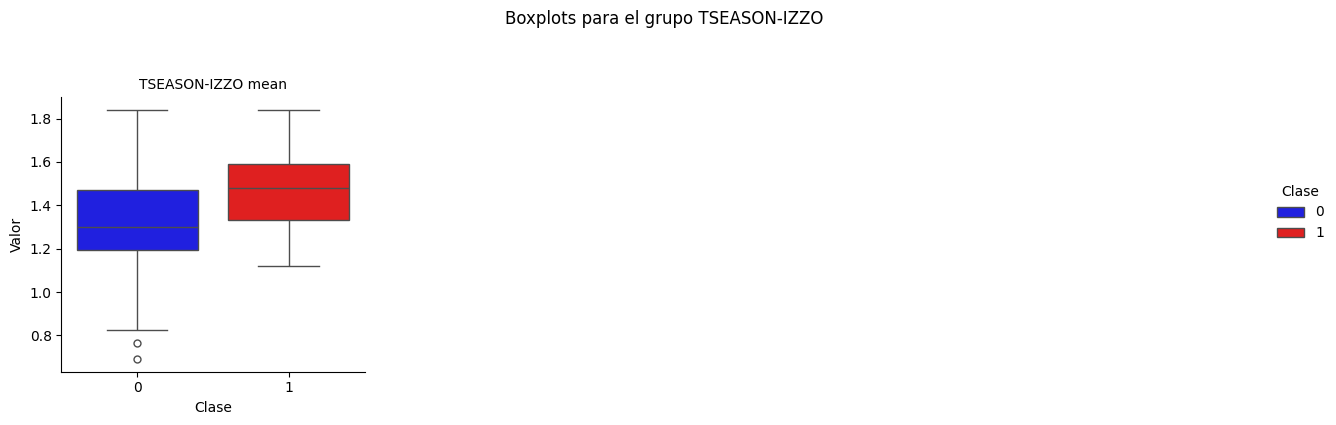

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


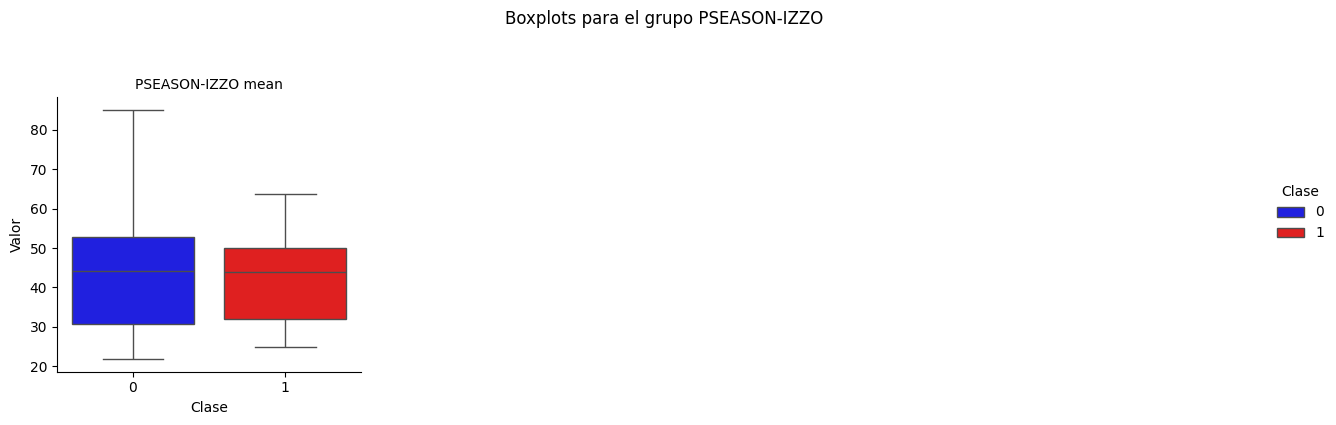

In [33]:
# Extraer grupos de variables basado en el prefijo antes del primer espacio
groups = pa_with_features.columns.str.split().str[0].unique()  # Lista de nombres de grupos únicos

# Crear paleta de colores personalizada para CLASS=0 (azul) y CLASS=1 (rojo)
palette = {0: "blue", 1: "red"}

# Generar boxplots para cada grupo en una celda separada
for group in groups:
    # Filtrar las variables que pertenecen al grupo actual
    variables_group = [col for col in pa_with_features.columns if col.startswith(group) and col not in ['CLASS', 'geometry', 'index_right', 'hex_id']]
    
    if variables_group:  # Proceder solo si el grupo tiene variables
        # Convertir el DataFrame filtrado al formato largo con `CLASS` en el eje X
        df_long = pd.melt(pa_with_features, id_vars='CLASS', value_vars=variables_group, var_name='variable', value_name='value')
        
        # Crear el gráfico de boxplots para este grupo con `hue="CLASS"`
        g = sns.catplot(
            data=df_long,
            x="CLASS", y="value",
            hue="CLASS",  # Añadir `CLASS` como "hue" para diferenciar colores
            palette=palette,  # Aplicar paleta de colores personalizada
            col="variable", col_wrap=4,  # Ajusta col_wrap según el número de gráficos por fila
            kind="box", height=4, aspect=0.8, sharey=False
        )

        # Configurar títulos y mejorar etiquetas en el eje X
        g.set_titles("{col_name}")
        g.set_axis_labels("Clase", "Valor")  # Etiquetas comunes en los ejes
        g._legend.set_title("Clase")  # Título de la leyenda para CLASS
        
        plt.suptitle(f"Boxplots para el grupo {group}", y=1.05)  # Título de la figura con el nombre del grupo
        plt.tight_layout()
        plt.show()


## Excluir columnas de geometría, índice y variable respuesta

In [34]:
# Columnas de predictores ambientales en `va7`
feature_columns = [col for col in va7.columns if col not in ['geometry', 'hex_id', 'index_right', 'CLASS']]
pa_with_features = pa_with_features.dropna(subset=feature_columns)
train_xs = pa_with_features[feature_columns].values  # Convertir predictores a matriz de numpy
train_y = pa_with_features['CLASS'].values  # Vector de respuesta
# 2. Prepara `target_xs` para predicción: todos los hexágonos en `va7` sin filtro
target_xs = va7[feature_columns].dropna().values  # Matriz de predictores para todos los hexágonos

## Entrenar y predecir

In [35]:
# 1. Entrenamiento y predicción sobre vectores en lugar de rásters
CLASS_MAP = {
    'rf': RandomForestClassifier(),
    'et': ExtraTreesClassifier(),
    'xgb': XGBClassifier(),
    'lgbm': LGBMClassifier(verbose=-1) # verbose=-1 para suprimir advertencias
}

# Iterar sobre los modelos para entrenamiento y predicción
for name, model in CLASS_MAP.items():
    # Validación cruzada con k-fold
    k = 5  # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(f"Clasificador {name}.\nPrecisión de la validación cruzada con {k} particiones: {accuracy_scores.mean() * 100:.2f}% (+/- {accuracy_scores.std() * 200:.2f}%)")

    # Entrenar el modelo con todos los datos de entrenamiento
    model.fit(train_xs, train_y)
    
    # Realizar predicciones sobre los hexágonos en `va7_pred`
    va7_pred = va7.dropna().copy()
    # va7_pred['CLASS_pred_' + name] = model.predict(target_xs)
    va7_pred['CLASS_pred_' + name] = model.predict_proba(target_xs)[:, 1] # Probabilidad de clase `1`

    # Guardar la salida en un archivo GeoPackage o Shapefile, según prefieras
    output_dir = 'salidas'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"{name}_predictions.gpkg")
    va7_pred[['geometry', 'CLASS_pred_' + name]].to_file(output_file, driver="GPKG")

    print(f"Predicciones de {name} guardadas en {output_file}\n")

Clasificador rf.
Precisión de la validación cruzada con 5 particiones: 71.24% (+/- 68.82%)


INFO:Created 12,990 records


Predicciones de rf guardadas en salidas/rf_predictions.gpkg

Clasificador et.
Precisión de la validación cruzada con 5 particiones: 70.68% (+/- 67.75%)


INFO:Created 12,990 records


Predicciones de et guardadas en salidas/et_predictions.gpkg

Clasificador xgb.
Precisión de la validación cruzada con 5 particiones: 69.54% (+/- 65.75%)


INFO:Created 12,990 records


Predicciones de xgb guardadas en salidas/xgb_predictions.gpkg

Clasificador lgbm.
Precisión de la validación cruzada con 5 particiones: 69.26% (+/- 66.06%)


INFO:Created 12,990 records


Predicciones de lgbm guardadas en salidas/lgbm_predictions.gpkg



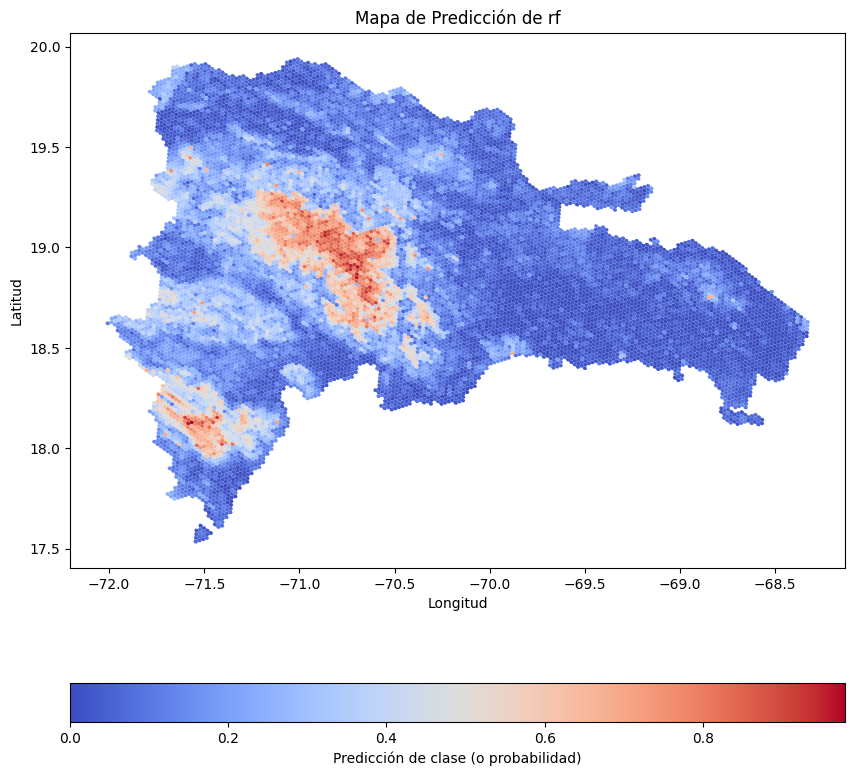

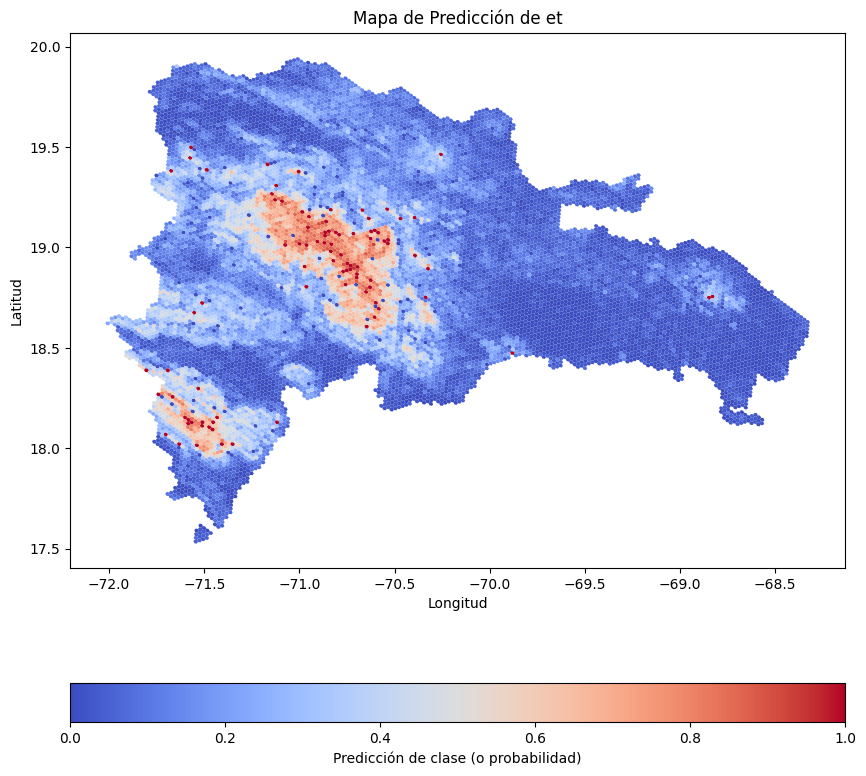

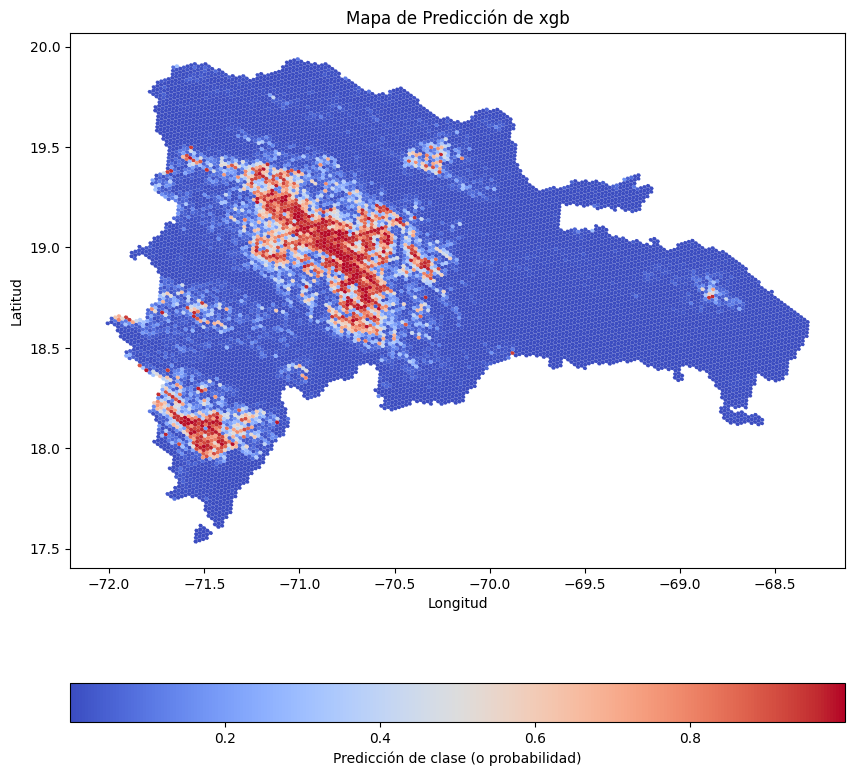

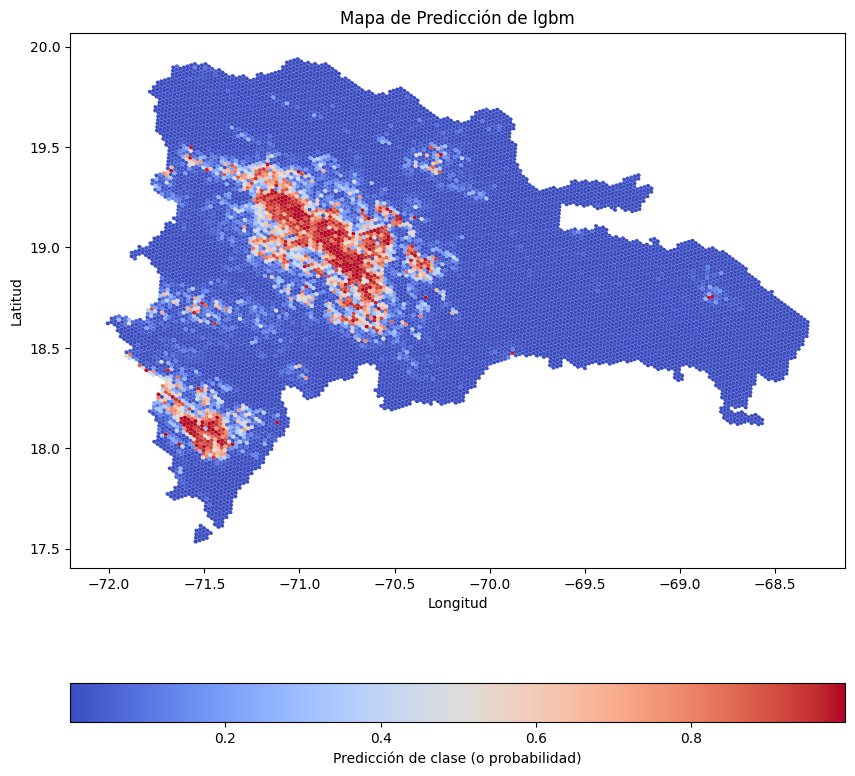

In [36]:
# Buscar archivos .gpkg de predicción en el directorio `salidas`
pred_files = sorted(glob.glob("salidas/*_predictions.gpkg"))  # Lista ordenada de archivos de predicciones en GeoPackage
pred_files = [pred_files[i] for i in [2, 0, 3, 1]]

# Iterar sobre cada archivo de predicción para generar su mapa
for pred_file in pred_files:
    # Cargar el archivo .gpkg en un GeoDataFrame
    gdf_pred = gpd.read_file(pred_file)
    
    # Extraer el nombre del modelo desde el nombre del archivo
    model_name = pred_file.split('/')[-1].split('_')[0]
    
    # Crear un gráfico donde cada hexágono se colorea según la columna de predicción
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_pred.plot(column=f'CLASS_pred_{model_name}', ax=ax, cmap="coolwarm", legend=True,
                  legend_kwds={'label': "Predicción de clase (o probabilidad)", 'orientation': "horizontal"})
    
    # Configurar título y ejes
    ax.set_title(f"Mapa de Predicción de {model_name}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    
    # Mostrar el gráfico
    plt.show()

## Referencias

GBIF.org (2023). *What is GBIF?* Retrieved from
<https://www.gbif.org/what-is-gbif>

H3 (2022). *Introduction \| H3*. Retrieved from
<https://h3geo.org/docs>

José Ramón Martínez-Batlle (2022). Estadística zonal multipropósito sobre información geoespacial de República Dominicana, usando Google Earth Engine, Python y R. Versión "Let there be environmental variables (v0.0.0.9000)". Zenodo <https://doi.org/10.5281/zenodo.7367256>